In [ ]:
# ================================
# Step 1 — Important Libraries
# (Install + Imports + Basic Env Setup)
# ================================

# --- If you're in a fresh Colab/VM environment, UNCOMMENT the following to install extras:
# !pip install -q timm albumentations==1.4.7 torchinfo GPUtil psutil

# ----------------
# Standard utils
# ----------------
import os                 # file/folder ops
import sys                # python runtime info
import time               # timing (training/inference duration)
import math               # math helpers
import random             # seeding for python-level RNG
from pathlib import Path  # cleaner path handling

# ----------------
# Data handling
# ----------------
import numpy as np        # arrays, number crunching
import pandas as pd       # lightweight tabular summaries (optional)

# ----------------
# Image I/O & Augmentations
# ----------------
from PIL import Image                           # image loading/saving
import cv2                                      # OpenCV for image ops (BGR note!)
import albumentations as A                      # data augmentation library
from albumentations.pytorch import ToTensorV2   # convert Albumentations -> PyTorch tensor

# ----------------
# Visualization (for quick checks/plots)
# ----------------
import matplotlib.pyplot as plt  # plotting (curves, confusion matrix heatmaps, etc.)

# ----------------
# PyTorch Core
# ----------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Enable benchmark for fixed-size images; can speed up cuDNN
torch.backends.cudnn.benchmark = True

# ----------------
# Models (ViTs, Swin) via timm
# ----------------
import timm  # provides pretrained DeiT, Swin, and many others

# ----------------
# Metrics & Evaluation
# ----------------
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_auc_score
)




In [ ]:
!pip install -q torchinfo GPUtil psutil
# ----------------
# Logging / Progress / System
# ----------------
from tqdm.auto import tqdm            # progress bars
import psutil                         # CPU/RAM usage
import GPUtil                         # GPU usage (utilization, memory)
from torchinfo import summary         # model summary (params, MACs approx.)

  Preparing metadata (setup.py) ... done


In [ ]:
# ================================
# Basic device check & environment print
# ================================
def get_device():
    """Return the best available device (GPU if available, else CPU)."""
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def print_env_summary():
    """Print a concise environment summary useful for reproducibility."""
    print("=== Environment Summary ===")
    print(f"Python:    {sys.version.split()[0]}")
    print(f"PyTorch:   {torch.__version__}")
    print(f"CUDA:      {torch.version.cuda if torch.cuda.is_available() else 'Not available'}")
    print(f"cuDNN:     {torch.backends.cudnn.version() if torch.cuda.is_available() else 'Not available'}")
    print(f"timm:      {timm.__version__}")
    print(f"Numpy:     {np.__version__}")
    print(f"Pandas:    {pd.__version__}")
    print(f"OpenCV:    {cv2.__version__}")
    print(f"Albument.: {A.__version__}")
    print("---------------------------")
    if torch.cuda.is_available():
        gpu = torch.cuda.get_device_name(0)
        print(f"GPU:       {gpu}")
        try:
            gpus = GPUtil.getGPUs()
            if gpus:
                g = gpus[0]
                print(f"GPU Util.: {g.load * 100:.1f}% | Mem: {g.memoryUsed:.1f}/{g.memoryTotal:.1f} MB")
        except Exception:
            # GPUtil might not have permission in some environments—safe to continue
            pass
    else:
        print("Running on CPU.")

DEVICE = get_device()
print_env_summary()


=== Environment Summary ===
Python:    3.12.11
PyTorch:   2.8.0+cu126
CUDA:      12.6
cuDNN:     91002
timm:      1.0.19
Numpy:     2.0.2
Pandas:    2.2.2
OpenCV:    4.12.0
Albument.: 2.0.8
---------------------------
GPU:       Tesla T4
GPU Util.: 0.0% | Mem: 2.0/15360.0 MB


In [ ]:
# ================================
# Helper: Set Global Seeds (we'll reuse later)
# ================================
def set_global_seed(seed: int = 42):
    """
    Set seeds for reproducibility. Call this at the start of each run.
    (Note: full determinism may reduce performance; enable only if needed.)
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    # For more deterministic behavior (may slow down training):
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

set_global_seed(42)


In [ ]:
# ============================================
# Step 2 — Data Preparation (Colab + Drive)
# Folder layout (inside one "setup" root):
#   DATA_ROOT/
#     training/
#       class_0/ ...images...
#       ...
#       class_7/
#     validation/
#       class_0/ ...images...
#       ...
#     testing/
#       class_0/ ...images...
#       ...
# ============================================

# --- Colab: mount Google Drive ---
from google.colab import drive
#drive.mount('/content/drive')

# >>> EDIT THIS to actual dataset location in Drive:
# e.g., '/content/drive/MyDrive/BreakHis/mixed' or '/content/drive/MyDrive/BreakHis/100x'
DATA_ROOT = '/content/drive/MyDrive/Mixed'  # <-- point to ONE setup root at a time

import os
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

# -----------------------------
# 2.1 Robust image load (RGB)
# -----------------------------
def load_image_rgb(path: str) -> np.ndarray:
    """
    Load an image via OpenCV and return RGB (HxWxC) uint8.
    Ensures images are in RGB for consistent downstream processing.
    """
    img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Failed to read image: {path}")
    # If grayscale -> convert to RGB
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV loads BGR -> convert to RGB
    return img


In [ ]:
# --------------------------------------------
# 2.2 Utilities for class discovery & counting
# --------------------------------------------
def list_classes(split_dir: Path) -> List[str]:
    """Return sorted list of class names (subdirectories) under a split dir."""
    classes = [p.name for p in split_dir.iterdir() if p.is_dir()]
    classes.sort()
    if not classes:
        raise RuntimeError(f"No class folders found inside: {split_dir}")
    return classes

def count_images_in_class(class_dir: Path) -> int:
    """Count images in a class directory (common extensions)."""
    exts = {".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp"}
    return sum(1 for p in class_dir.rglob("*") if p.suffix.lower() in exts)



In [ ]:
# -------------------------------------------------------
# 2.3 Directory integrity check for your split names
# -------------------------------------------------------
def directory_integrity_check_colab(
    data_root: str,
    expected_per_class: Dict[str, int],  # e.g., {"training": 140, "validation": 30, "testing": 30}
    verbose: bool = True
) -> Dict[str, Dict[str, int]]:
    """
    Verify each split (training/validation/testing) has the expected number of images per class.
    Returns counts[split][class_name] = n_images
    """
    splits = ["training", "validation", "testing"]
    data_root = Path(data_root)
    if not data_root.exists():
        raise FileNotFoundError(f"DATA_ROOT not found: {data_root}")

    all_counts = {s: {} for s in splits}

    for split in splits:
        split_path = data_root / split
        if not split_path.exists():
            raise FileNotFoundError(f"Missing split folder: {split_path}")

        classes = list_classes(split_path)
        if verbose:
            print(f"[{split}] classes:", classes)

        for cls in classes:
            cdir = split_path / cls
            n = count_images_in_class(cdir)
            all_counts[split][cls] = n
            exp = expected_per_class.get(split, None)
            if exp is None:
                raise KeyError(f"No expected count provided for split '{split}'.")
            assert n == exp, (
                f"Count mismatch for {split}/{cls}: found {n}, expected {exp}"
            )

        if verbose:
            total_split = sum(all_counts[split].values())
            print(f"[{split}] OK — per-class counts match. Total images: {total_split}")

    return all_counts



In [ ]:
# --------------------------------------------
# 2.4 Transforms: resize + ImageNet normalize
# --------------------------------------------
# ---- Step 2.4 — FIXED build_transforms ----
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

def build_transforms(
    input_size: int = 224,
    mode: str = "training",          # "training", "validation", "testing"
    policy: str = "baseline"         # "baseline" | "color_jitter"
) -> A.Compose:
    assert mode in {"training", "validation", "testing"}
    assert policy in {"baseline", "color_jitter"}

    ops = []
    if mode == "training":
        ops += [
            A.SmallestMaxSize(max_size=input_size, interpolation=cv2.INTER_AREA),
            # Albumentations expects a tuple for `size`
            A.RandomResizedCrop(size=(input_size, input_size), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.5),
        ]
        if policy == "color_jitter":
            ops += [A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02, p=0.7)]
    else:
        ops += [
            A.SmallestMaxSize(max_size=input_size, interpolation=cv2.INTER_AREA),
            A.CenterCrop(height=input_size, width=input_size),
        ]

    ops += [
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD, max_pixel_value=255.0),
        ToTensorV2()
    ]
    return A.Compose(ops)


In [ ]:
# -----------------------------------------------------------------
# 2.5 (Optional) Stain handling hooks — placeholders OFF by default
# -----------------------------------------------------------------
def simple_hed_jitter(img_rgb: np.ndarray, alpha: float = 0.05) -> np.ndarray:
    """
    Mild H&E-like perturbation proxy (NOT true Macenko/Vahadane).
    Use only for ablation to test robustness; keep disabled by default.
    """
    img = img_rgb.astype(np.float32) + 1.0
    od = -np.log(img / 255.0)
    noise = np.random.normal(0, alpha, size=od.shape).astype(np.float32)
    od_perturbed = np.clip(od + noise, 0, None)
    out = np.clip(np.exp(-od_perturbed) * 255.0, 0, 255).astype(np.uint8)
    return out

def macenko_normalize_placeholder(img_rgb: np.ndarray) -> np.ndarray:
    # TODO: integrate a real Macenko normalizer if you decide to run this ablation.
    return img_rgb

def vahadane_normalize_placeholder(img_rgb: np.ndarray) -> np.ndarray:
    # TODO: integrate a real Vahadane normalizer if you decide to run this ablation.
    return img_rgb


In [ ]:
# -------------------------------------------------------
# 2.6 Dataset class for (training/validation/testing)
# -------------------------------------------------------
from torch.utils.data import Dataset

class HistopathologyFolderDataset(Dataset):
    """
    Directory-based dataset for a single setup root (DATA_ROOT).
    Expects split subfolders: training/validation/testing, each containing class folders.
    Applies:
      - Robust RGB loading (QC)
      - Optional stain ablation hook (disabled by default)
      - Resize & ImageNet normalization via Albumentations
    """
    def __init__(
        self,
        data_root: str,
        split: str,                         # "training" | "validation" | "testing"
        classes: Optional[List[str]] = None,
        input_size: int = 224,
        transform_policy: str = "baseline", # "baseline" | "color_jitter"
        stain_ablation: Optional[str] = None  # None | "hed_jitter" | "macenko" | "vahadane"
    ):
        super().__init__()
        self.data_root = Path(data_root)
        self.split = split
        self.root = self.data_root / split

        if not self.root.exists():
            raise FileNotFoundError(f"Split folder not found: {self.root}")

        if classes is None:
            self.classes = list_classes(self.root)
        else:
            self.classes = sorted(classes)

        exts = {".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp"}
        items = []
        for cid, cls in enumerate(self.classes):
            cdir = self.root / cls
            for p in cdir.rglob("*"):
                if p.suffix.lower() in exts:
                    items.append((str(p), cid))
        if not items:
            raise RuntimeError(f"No images found in {self.root}")

        self.items = items
        self.input_size = input_size
        self.transform = build_transforms(input_size=input_size, mode=split, policy=transform_policy)
        self.stain_ablation = stain_ablation

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx: int):
        path, label = self.items[idx]
        img = load_image_rgb(path)  # QC: enforce RGB

        # Optional stain ablation (disabled by default)
        if self.stain_ablation is not None:
            if self.stain_ablation == "hed_jitter":
                img = simple_hed_jitter(img, alpha=0.05)
            elif self.stain_ablation == "macenko":
                img = macenko_normalize_placeholder(img)
            elif self.stain_ablation == "vahadane":
                img = vahadane_normalize_placeholder(img)
            else:
                raise ValueError(f"Unknown stain_ablation: {self.stain_ablation}")

        img = self.transform(image=img)["image"]
        return img, label

In [ ]:
#--------------------------------
# 2.7 Example usage (adjust expected counts to your plan)
# -------------------------------------------------------
# Expected images per class per split for this setup root:
expected_counts = {"training": 140, "validation": 30, "testing": 30}

# 1) Integrity check (asserts per-class counts match)
_ = directory_integrity_check_colab(DATA_ROOT, expected_counts, verbose=True)

# 2) Build datasets (baseline = no stain normalization)
train_ds = HistopathologyFolderDataset(DATA_ROOT, split="training",  input_size=224, transform_policy="baseline", stain_ablation=None)
val_ds   = HistopathologyFolderDataset(DATA_ROOT, split="validation", input_size=224, transform_policy="baseline", stain_ablation=None)
test_ds  = HistopathologyFolderDataset(DATA_ROOT, split="testing",   input_size=224, transform_policy="baseline", stain_ablation=None)

# (Optional) Color-jitter ablation for training:
#train_ds_cj = HistopathologyFolderDataset(DATA_ROOT, split="training", input_size=224,
                                           #transform_policy="color_jitter", stain_ablation=None)

#(Optional) Simple stain jitter ablation:
#train_ds_stain = HistopathologyFolderDataset(DATA_ROOT, split="training", input_size=224,
                                              #transform_policy="baseline", stain_ablation="hed_jitter")

print(f"Train/Val/Test sizes: {len(train_ds)} / {len(val_ds)} / {len(test_ds)}")
# End of Step 2


[training] classes: ['adenosis_0', 'ductalcarcenoma_1', 'fibroadenoma_0', 'lubolarcarcenoma_1', 'mucinouscarcenoma_1', 'papillarycarcenoma_1', 'phyllodestumor_0', 'tubolaradenoma_0']
[training] OK — per-class counts match. Total images: 1120
[validation] classes: ['adenosis_0', 'ductalcarcenoma_1', 'fibroadenoma_0', 'lubolarcarcenoma_1', 'mucinouscarcenoma_1', 'papillarycarcenoma_1', 'phyllodestumor_0', 'tubolaradenoma_0']
[validation] OK — per-class counts match. Total images: 240
[testing] classes: ['adenosis_0', 'ductalcarcenoma_1', 'fibroadenoma_0', 'lubolarcarcenoma_1', 'mucinouscarcenoma_1', 'papillarycarcenoma_1', 'phyllodestumor_0', 'tubolaradenoma_0']
[testing] OK — per-class counts match. Total images: 240
Train/Val/Test sizes: 1120 / 240 / 240


In [ ]:
# ============================================
# Step 3 — Reproducibility
# - Fixed seeds (Python/NumPy/PyTorch)
# - Frozen splits: write file lists for training/validation/testing
# - Env lock: save library versions, GPU/CUDA info
# - Run config: save a config.yaml for this experiment
# - Checkpointing helper: save best model by validation macro-F1
# ============================================

import os, sys, json, time, socket
from pathlib import Path
from datetime import datetime
from typing import Dict, Any, List, Tuple, Optional

import torch
import numpy as np
import random
import yaml

# If you used set_global_seed in Step 1, you can reuse it; re-define here for completeness.
def set_global_seed(seed: int = 42, deterministic: bool = False):
    """
    Set seeds for reproducibility.
    deterministic=True will enforce cudnn deterministic ops (slower).
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # multi-GPU safety

    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:
        # Good default for speed with fixed input shapes
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True

# Call once at the start of each run
set_global_seed(42, deterministic=False)

# ---------------------------
# 3.1 Run directory bootstrap
# ---------------------------
RUNS_ROOT = Path("/content/drive/MyDrive/DEITMixed_BreakHis/runs")  # <-- adjust if you prefer
RUNS_ROOT.mkdir(parents=True, exist_ok=True)

RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_DIR = RUNS_ROOT / RUN_ID
(RUN_DIR / "splits").mkdir(parents=True, exist_ok=True)
(RUN_DIR / "checkpoints").mkdir(parents=True, exist_ok=True)
print(f"[Repro] Run directory: {RUN_DIR}")


[Repro] Run directory: /content/drive/MyDrive/DEITMixed_BreakHis/runs/20250914_164244


In [ ]:
# -----------------------------------------
# 3.2 Frozen splits: write file lists to txt
# -----------------------------------------
def _dataset_items_to_paths(ds) -> List[str]:
    """
    Convert dataset items -> file paths (without loading images).
    Works with HistopathologyFolderDataset that stores (path, label).
    """
    # Our dataset stored `self.items` as list[(path, label_id)]
    # We only need the image paths for splits.
    return [p for (p, _) in ds.items]

def save_split_lists(train_ds, val_ds, test_ds, out_dir: Path):
    out_dir.mkdir(parents=True, exist_ok=True)
    def _write_list(paths: List[str], filename: str):
        with open(out_dir / filename, "w") as f:
            for p in sorted(paths):
                f.write(f"{p}\n")

    train_list = _dataset_items_to_paths(train_ds)
    val_list   = _dataset_items_to_paths(val_ds)
    test_list  = _dataset_items_to_paths(test_ds)

    _write_list(train_list, "train_files.txt")
    _write_list(val_list,   "val_files.txt")
    _write_list(test_list,  "test_files.txt")

    print(f"[Repro] Frozen split files written to: {out_dir}")
    print(f"  train_files.txt: {len(train_list)}")
    print(f"  val_files.txt:   {len(val_list)}")
    print(f"  test_files.txt:  {len(test_list)}")

# Assumes you built train_ds / val_ds / test_ds in Step 2
save_split_lists(train_ds, val_ds, test_ds, RUN_DIR / "splits")


[Repro] Frozen split files written to: /content/drive/MyDrive/DEITMixed_BreakHis/runs/20250914_164244/splits
  train_files.txt: 1120
  val_files.txt:   240
  test_files.txt:  240


In [ ]:
# -------------------------------
# 3.3 Environment lock (env_lock)
# -------------------------------
def collect_env_lock() -> Dict[str, Any]:
    """Capture key environment info for reproducibility."""
    try:
        import albumentations as A
        alb_ver = A.__version__
    except Exception:
        alb_ver = "unknown"

    try:
        import timm
        timm_ver = timm.__version__
    except Exception:
        timm_ver = "unknown"

    try:
        import cv2
        cv2_ver = cv2.__version__
    except Exception:
        cv2_ver = "unknown"

    try:
        import pandas as pd
        pd_ver = pd.__version__
    except Exception:
        pd_ver = "unknown"

    try:
        import GPUtil
        gpus = GPUtil.getGPUs()
        gpu_info = [{
            "id": g.id, "name": g.name, "mem_total_mb": g.memoryTotal,
            "driver": None  # GPUtil doesn't give driver; leave None
        } for g in gpus]
    except Exception:
        gpu_info = []

    env = {
        "timestamp": datetime.now().isoformat(),
        "hostname": socket.gethostname(),
        "python": sys.version.split()[0],
        "pytorch": torch.__version__,
        "cuda_available": torch.cuda.is_available(),
        "cuda_version": torch.version.cuda if torch.cuda.is_available() else None,
        "cudnn_version": torch.backends.cudnn.version() if torch.cuda.is_available() else None,
        "libraries": {
            "numpy": np.__version__,
            "albumentations": alb_ver,
            "timm": timm_ver,
            "opencv": cv2_ver,
            "pandas": pd_ver,
        },
        "gpu": gpu_info,
    }
    return env

ENV_LOCK = collect_env_lock()
with open(RUN_DIR / "env_lock.json", "w") as f:
    json.dump(ENV_LOCK, f, indent=2)
print(f"[Repro] Saved env lock -> {RUN_DIR/'env_lock.json'}")



[Repro] Saved env lock -> /content/drive/MyDrive/DEITMixed_BreakHis/runs/20250914_164244/env_lock.json


In [ ]:
# -----------------------
# 3.4 Save run config
# -----------------------
# This config is what you *intend* to use for this run.
# Update fields when you change hyperparams/model/paths in future steps.
RUN_CONFIG = {
    "data_root": DATA_ROOT,
    "splits": {
        "training": 140,
        "validation": 30,
        "testing": 30
    },
    "input_size": 224,
    "normalization": {
        "mean": [0.485, 0.456, 0.406],
        "std":  [0.229, 0.224, 0.225]
    },
    "augmentation_policy": "baseline",   # or "color_jitter"
    "model": {
        "arch": "deit_small_patch16_224",  # placeholder; change per run (e.g., "swin_tiny_patch4_window7_224")
        "num_classes": len(train_ds.classes),
        "pretrained": True,
        "stochastic_depth": "default",
        "dropout": "default"
    },
    "optimizer": {
        "name": "AdamW",
        "lr": 3e-4,
        "weight_decay": 0.05
    },
    "scheduler": {
        "name": "cosine",
        "warmup_epochs": 5
    },
    "training": {
        "epochs": 100,
        "batch_size": 32,    # adjust to your GPU
        "amp": True,
        "grad_clip": 1.0,
        "early_stop_patience": 10,
        "seed": 42,
        "deterministic": False
    },
    "selection_metric": "val_macroF1",   # tie-breaker: val_accuracy
    "run_id": RUN_ID
}

with open(RUN_DIR / "config.yaml", "w") as f:
    yaml.safe_dump(RUN_CONFIG, f, sort_keys=False)
print(f"[Repro] Saved run config -> {RUN_DIR/'config.yaml'}")



[Repro] Saved run config -> /content/drive/MyDrive/DEITMixed_BreakHis/runs/20250914_164244/config.yaml


In [ ]:
# ------------------------------------------------------
# 3.5 Checkpointing helper (save best by val macro-F1)
# ------------------------------------------------------
class BestCheckpoint:
    """
    Tracks the best validation metric and saves checkpoint when it improves.
    Usage in training loop (later):
        ckpt = BestCheckpoint(ckpt_dir, primary_metric="val_macroF1", tie_metric="val_accuracy")
        ...
        val_metrics = {"val_macroF1": macro_f1, "val_accuracy": acc}
        ckpt.maybe_save(model, optimizer, epoch, val_metrics, extra=RUN_CONFIG)
    """
    def __init__(self, ckpt_dir: Path, primary_metric: str = "val_macroF1", tie_metric: str = "val_accuracy"):
        self.ckpt_dir = Path(ckpt_dir)
        self.ckpt_dir.mkdir(parents=True, exist_ok=True)
        self.primary_metric = primary_metric
        self.tie_metric = tie_metric
        self.best_primary = -float("inf")
        self.best_tie = -float("inf")
        self.best_epoch = -1
        self.best_path = None

    def _is_better(self, primary: float, tie: float) -> bool:
        if primary > self.best_primary:
            return True
        if np.isclose(primary, self.best_primary) and tie > self.best_tie:
            return True
        return False

    def maybe_save(
        self,
        model: torch.nn.Module,
        optimizer: Optional[torch.optim.Optimizer],
        epoch: int,
        val_metrics: Dict[str, float],
        extra: Optional[Dict[str, Any]] = None
    ) -> bool:
        primary = float(val_metrics.get(self.primary_metric, -1e9))
        tie = float(val_metrics.get(self.tie_metric, -1e9))

        if self._is_better(primary, tie):
            self.best_primary = primary
            self.best_tie = tie
            self.best_epoch = epoch

            ckpt = {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict() if optimizer is not None else None,
                "val_metrics": val_metrics,
                "primary_metric": self.primary_metric,
                "tie_metric": self.tie_metric,
                "best_primary": self.best_primary,
                "best_tie": self.best_tie,
                "run_config": extra,
                "run_id": RUN_ID,
                "saved_at": datetime.now().isoformat()
            }
            save_path = self.ckpt_dir / f"best_{self.primary_metric}.pth"
            torch.save(ckpt, save_path)
            self.best_path = save_path
            print(f"[Checkpoint] Saved new best -> {save_path} (epoch={epoch}, {self.primary_metric}={primary:.4f}, {self.tie_metric}={tie:.4f})")
            return True
        return False

# Prepare a checkpoint manager for later training steps
ckpt_mgr = BestCheckpoint(RUN_DIR / "checkpoints", primary_metric="val_macroF1", tie_metric="val_accuracy")
print("[Repro] Checkpoint manager ready (best by val_macroF1, tie-breaker val_accuracy).")


[Repro] Checkpoint manager ready (best by val_macroF1, tie-breaker val_accuracy).


In [ ]:
# ============================================
# Step 4 — Data Visualization (before training)
# - Dataset cards: bar charts for train/val/test counts per class
# - (Optional) Per-magnification bars IF file paths contain "100x"/"400x"
# - Grid previews: 4–8 samples per class
# - t-SNE (optional): visualize class separation using pretrained encoder features
# ============================================

import os, random
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from torch.utils.data import DataLoader
import timm
from sklearn.manifold import TSNE

# Reuse from previous steps:
# - list_classes, count_images_in_class
# - load_image_rgb
# - HistopathologyFolderDataset
# - build_transforms
# - DEVICE (from Step 1)



In [ ]:
# -------------------------------
# 4.1 Dataset cards: bar charts
# -------------------------------
def collect_split_counts_by_class(data_root: str) -> Dict[str, Dict[str, int]]:
    """
    Returns dict: counts[split][class_name] = n_images
    For splits: training / validation / testing
    """
    data_root = Path(data_root)
    splits = ["training", "validation", "testing"]
    counts = {}
    for split in splits:
        split_path = data_root / split
        classes = list_classes(split_path)
        counts[split] = {}
        for cls in classes:
            counts[split][cls] = count_images_in_class(split_path / cls)
    return counts

def plot_counts_bar(counts: Dict[str, Dict[str, int]], title: str = "Dataset Card: Images per Class per Split"):
    """
    Bar chart per split; x-axis = classes; y = counts
    """
    splits = list(counts.keys())
    classes = sorted({c for split in splits for c in counts[split].keys()})
    x = np.arange(len(classes))
    width = 0.25

    plt.figure(figsize=(12, 5))
    for i, split in enumerate(splits):
        vals = [counts[split].get(cls, 0) for cls in classes]
        plt.bar(x + i*width, vals, width=width, label=split)

    plt.xticks(x + width, classes, rotation=45, ha="right")
    plt.ylabel("Images")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [ ]:
# ----------------------------------------------------------
# 4.2 Optional per-magnification bars (no persistent tagging)
#     This infers mag from the FILE PATH (e.g., contains "100x"/"400x")
# ----------------------------------------------------------
def _infer_magnification_from_path(p: str) -> Optional[str]:
    low = p.lower()
    if "100x" in low:
        return "100x"
    if "400x" in low:
        return "400x"
    return None  # unknown

def collect_mag_counts_by_class(data_root: str, split: str = "training") -> Optional[Dict[str, Dict[str, int]]]:
    """
    Returns dict: counts[class][mag] where mag ∈ {"100x","400x"} if these tokens appear in file paths.
    If neither token is found anywhere, returns None (skip).
    """
    data_root = Path(data_root)
    split_path = data_root / split
    if not split_path.exists():
        raise FileNotFoundError(split_path)

    classes = list_classes(split_path)
    counts = {cls: {"100x": 0, "400x": 0} for cls in classes}

    exts = {".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp"}
    found_any = False
    for cls in classes:
        for p in (split_path / cls).rglob("*"):
            if p.suffix.lower() in exts:
                mag = _infer_magnification_from_path(str(p))
                if mag in ("100x", "400x"):
                    counts[cls][mag] += 1
                    found_any = True

    return counts if found_any else None

def plot_mag_counts_bar(mag_counts: Dict[str, Dict[str, int]], split: str = "training"):
    """
    Bar chart for 100x vs 400x per class, for a given split.
    """
    classes = sorted(mag_counts.keys())
    x = np.arange(len(classes))
    width = 0.35

    vals_100 = [mag_counts[cls]["100x"] for cls in classes]
    vals_400 = [mag_counts[cls]["400x"] for cls in classes]

    plt.figure(figsize=(12, 5))
    plt.bar(x - width/2, vals_100, width=width, label="100x")
    plt.bar(x + width/2, vals_400, width=width, label="400x")
    plt.xticks(x, classes, rotation=45, ha="right")
    plt.ylabel("Images")
    plt.title(f"Per-Magnification Counts ({split})")
    plt.legend()
    plt.tight_layout()
    plt.show()



In [ ]:
# ----------------------------------------
# 4.3 Grid previews: n samples per class
# ----------------------------------------
def sample_images_per_class(
    data_root: str,
    split: str = "training",
    classes: Optional[List[str]] = None,
    n_per_class: int = 4,
    seed: int = 42
) -> Dict[str, List[str]]:
    """
    Returns {class: [file paths]} with up to n_per_class images per class.
    """
    random.seed(seed)
    data_root = Path(data_root)
    split_path = data_root / split
    if classes is None:
        classes = list_classes(split_path)

    exts = {".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp"}
    picks = {}
    for cls in classes:
        files = [str(p) for p in (split_path / cls).rglob("*") if p.suffix.lower() in exts]
        random.shuffle(files)
        picks[cls] = files[:n_per_class]
    return picks

def show_image_grid_per_class(
    picks: Dict[str, List[str]],
    n_cols: int = 4,
    suptitle: str = "Grid Previews (per class)"
):
    """
    Shows a grid per class; each row = one class, columns = images.
    """
    classes = list(picks.keys())
    n_rows = len(classes)
    n_cols = max(len(v) for v in picks.values()) if picks else n_cols

    plt.figure(figsize=(3*n_cols, 3*n_rows))
    plot_idx = 1
    for cls in classes:
        for p in picks[cls]:
            img = load_image_rgb(p)
            plt.subplot(n_rows, n_cols, plot_idx)
            plt.imshow(img)
            plt.axis("off")
            if plot_idx % n_cols == 1:
                plt.ylabel(cls, rotation=0, labelpad=40, va='center')
            plot_idx += 1
        # fill empty cells if class has fewer than n_cols images
        while (plot_idx-1) % n_cols != 0:
            plt.subplot(n_rows, n_cols, plot_idx)
            plt.axis("off")
            plot_idx += 1
    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()



In [ ]:
# -------------------------------------------------
# 4.4 t-SNE (optional): class separation preview
# -------------------------------------------------
@torch.no_grad()
def extract_features_with_timm(
    dataset: HistopathologyFolderDataset,
    model_name: str = "deit_small_patch16_224",
    batch_size: int = 32,
    max_images: int = 400,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Extract pooled features (num_classes=0) from a pretrained timm model for up to max_images.
    Returns (features [N,D], labels [N], class_names)
    """
    # Use a non-augmenting transform for features (val/test style)
    dataset_feat = HistopathologyFolderDataset(
        data_root=str(dataset.data_root),
        split=dataset.split,
        classes=dataset.classes,
        input_size=224,
        transform_policy="baseline",
        stain_ablation=None
    )

    # Limit to max_images for speed
    indices = np.arange(len(dataset_feat))
    if len(indices) > max_images:
        np.random.shuffle(indices)
        indices = indices[:max_images]
    subset_items = [dataset_feat.items[i] for i in indices]

    # Replace items so our DataLoader only iterates subset
    dataset_feat.items = subset_items

    loader = DataLoader(dataset_feat, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # Create model without classifier head (global_pool='avg' gives feature vectors)
    model = timm.create_model(model_name, pretrained=True, num_classes=0, global_pool='avg')
    model.eval().to(device)

    feats, labels = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        f = model(x)            # [B, D]
        feats.append(f.cpu().numpy())
        labels.append(y.numpy())
    feats = np.concatenate(feats, axis=0)
    labels = np.concatenate(labels, axis=0)
    return feats, labels, dataset_feat.classes

def tsne_plot_from_features(
    feats: np.ndarray,
    labels: np.ndarray,
    class_names: List[str],
    perplexity: float = 30.0,
    n_iter: int = 1000,
    title: str = "t-SNE of Pretrained Features"
):
    """
    Fit t-SNE on features and scatter colored by class.
    """
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, init="pca", learning_rate="auto")
    emb = tsne.fit_transform(feats)  # [N, 2]

    plt.figure(figsize=(8, 6))
    for cls_id, cls_name in enumerate(class_names):
        mask = (labels == cls_id)
        plt.scatter(emb[mask, 0], emb[mask, 1], s=12, alpha=0.7, label=cls_name)
    plt.legend(markerscale=1.5, fontsize=9, bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.title(title)
    plt.tight_layout()
    plt.show()




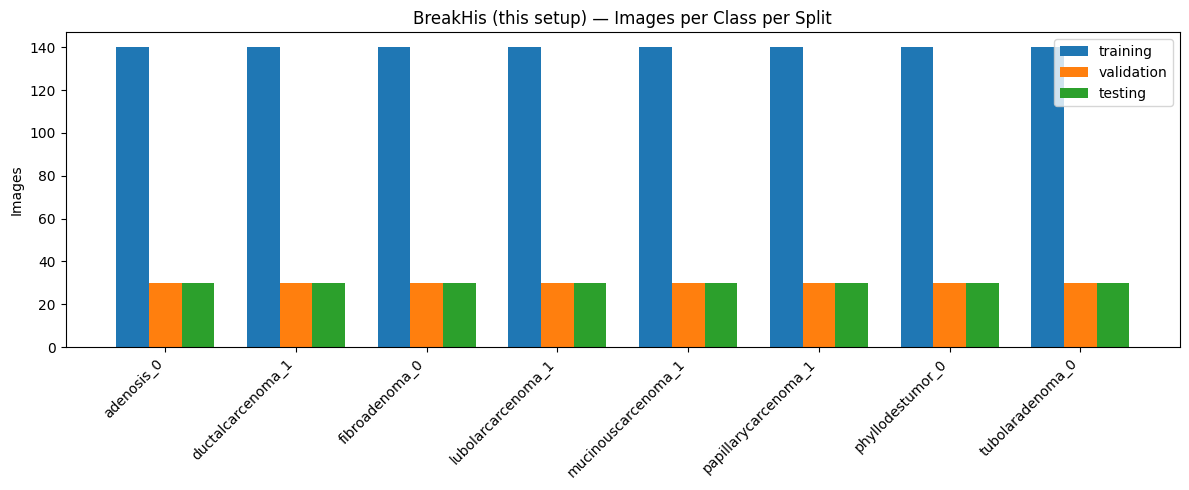

In [ ]:
# -----------------------------
# 4.5 Example usage (Colab)
# -----------------------------

# 1) Dataset card (counts per class per split)
counts = collect_split_counts_by_class(DATA_ROOT)
plot_counts_bar(counts, title="BreakHis (this setup) — Images per Class per Split")



In [ ]:
# 2) Optional per-magnification bars (only if paths contain '100x'/'400x')
mag_counts = collect_mag_counts_by_class(DATA_ROOT, split="training")
if mag_counts is not None:
    plot_mag_counts_bar(mag_counts, split="training")
else:
    print("No '100x'/'400x' tokens in file paths; skipping per-magnification chart.")



No '100x'/'400x' tokens in file paths; skipping per-magnification chart.


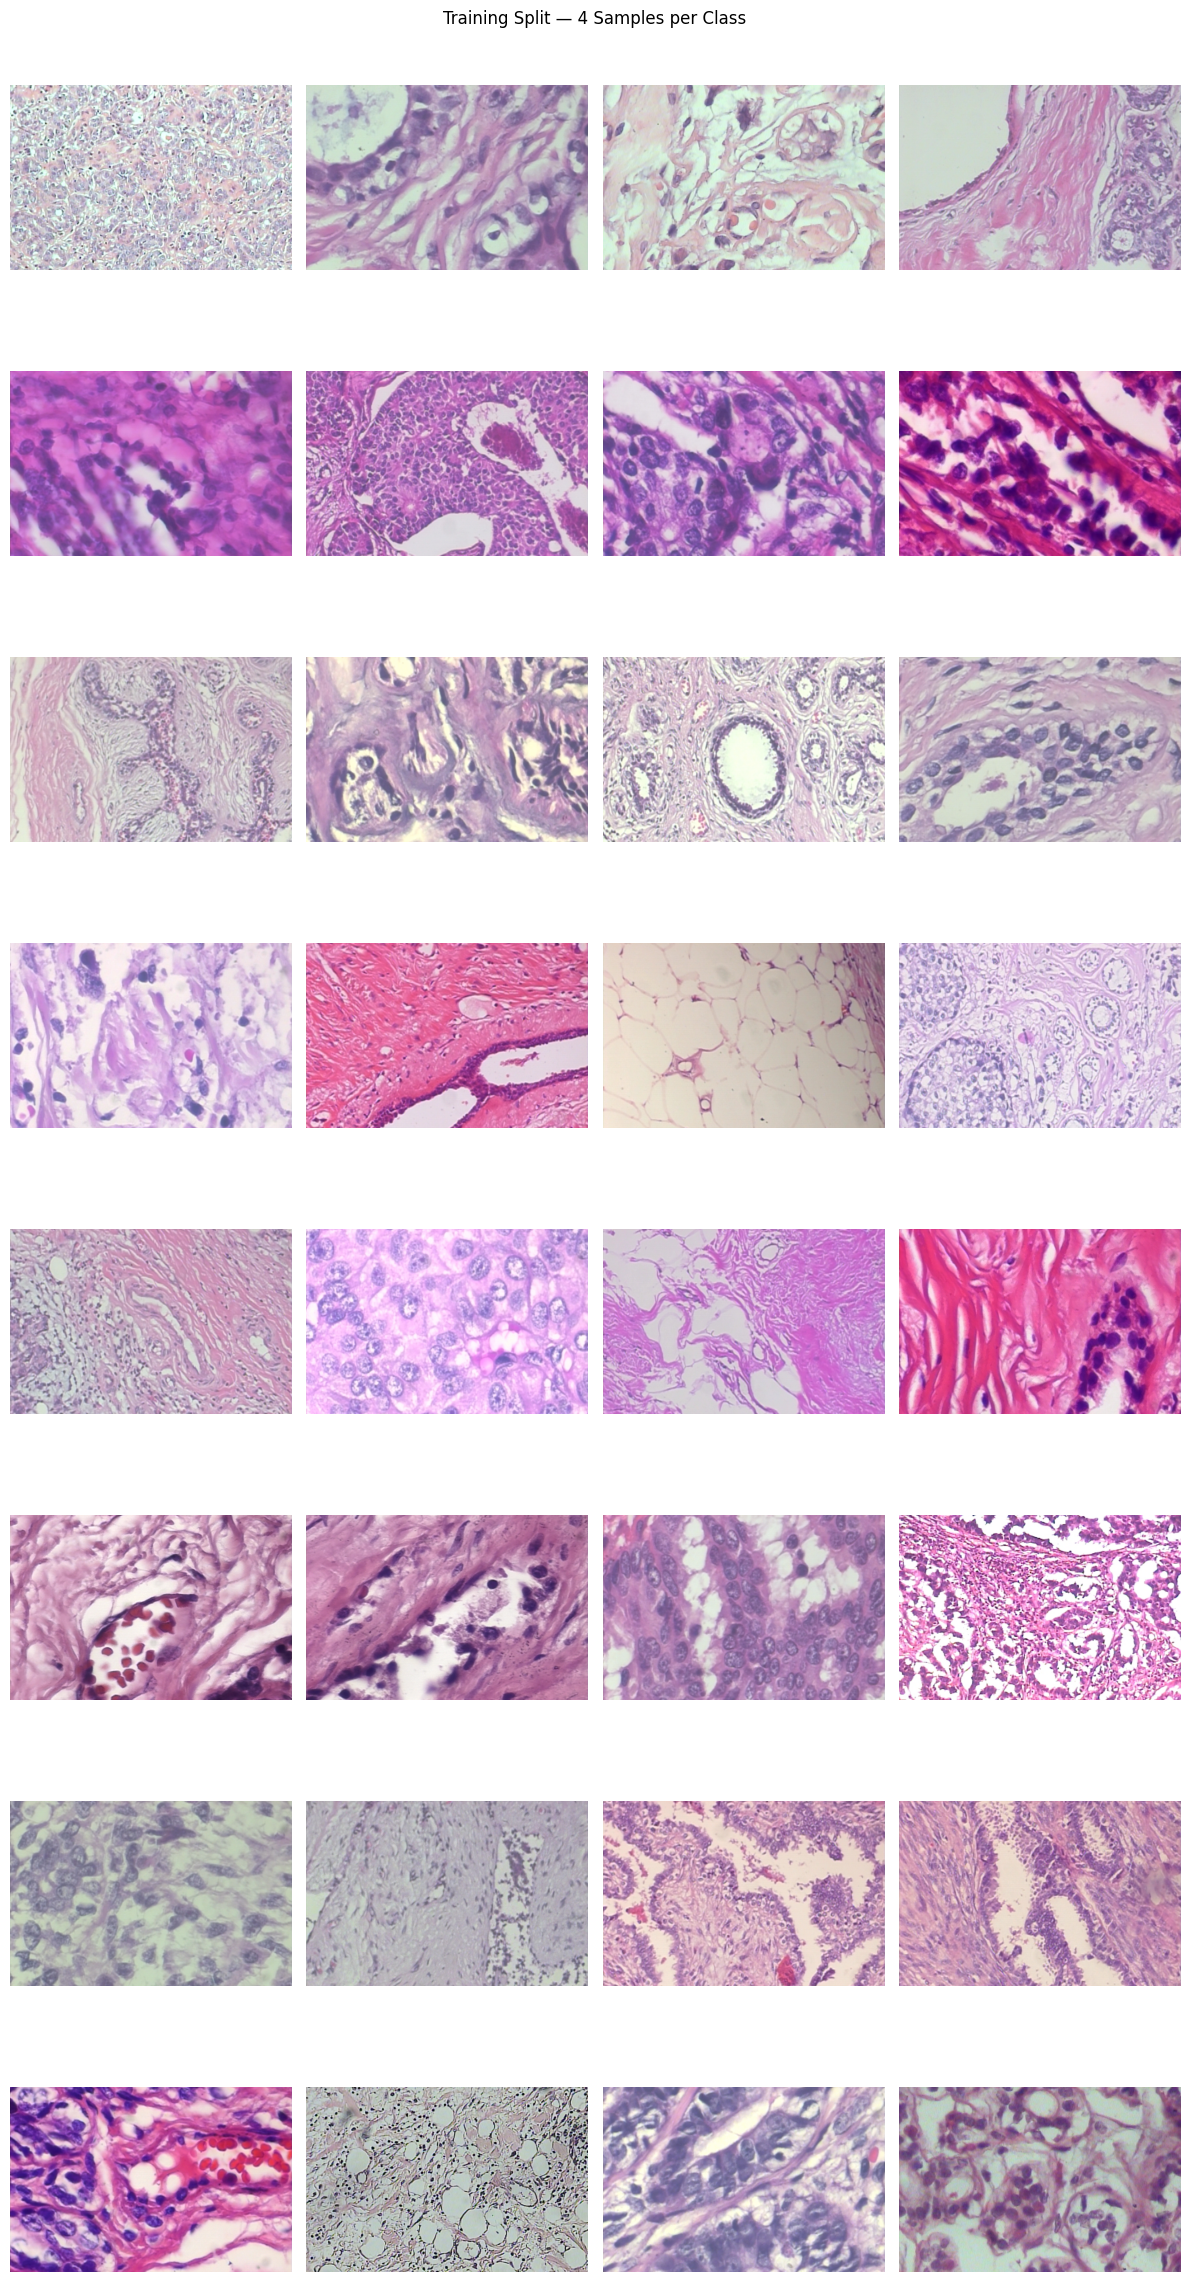

In [ ]:
# 3) Grid previews — e.g., 4 samples per class from training
picks = sample_images_per_class(DATA_ROOT, split="training", n_per_class=4, seed=42)
show_image_grid_per_class(picks, n_cols=4, suptitle="Training Split — 4 Samples per Class")



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


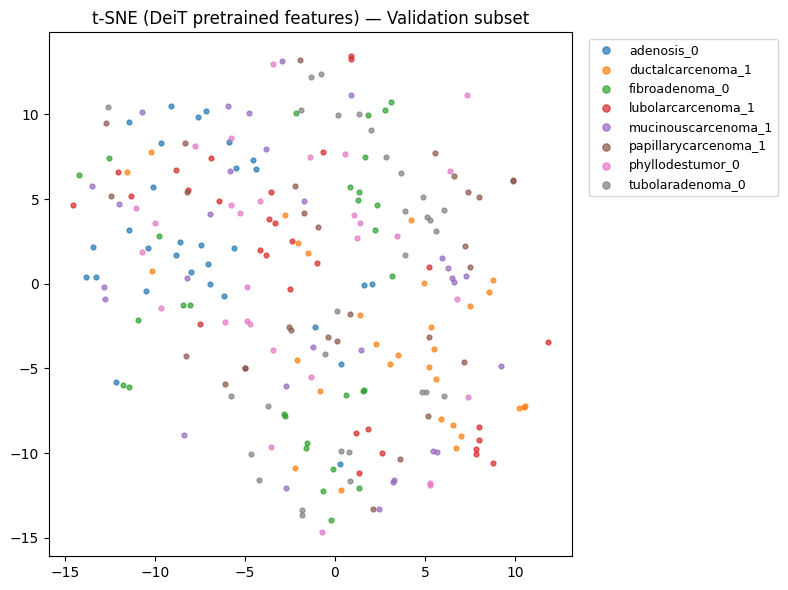

In [ ]:
# 4) Optional t-SNE — quick preview of class separability using pretrained DeiT features
# 4) Optional t-SNE (small subset). Comment out if slow.
# 1) Dataset card (counts per class per split)
counts = collect_split_counts_by_class(DATA_ROOT)
feat_ds = HistopathologyFolderDataset(DATA_ROOT, split="validation",
                                      input_size=224, transform_policy="baseline")
feats, labels, class_names = extract_features_with_timm(
    feat_ds, model_name="deit_small_patch16_224",
    batch_size=32, max_images=300, device=DEVICE
)
tsne_plot_from_features(
    feats, labels, class_names,
    perplexity=30.0, n_iter=1000,
    title="t-SNE (DeiT pretrained features) — Validation subset"
)
# End of Step 4


In [ ]:
# ============================================
# Step 5 — Augmentation Policy (identical across setups)
# - Geometric: H/V flips, small rotations, random resized crop
# - Photometric: light brightness/contrast/saturation/hue jitter (optional)
# - Histopath-specific (ablation): mild HED jitter OR HSV perturbation
#
# Compatible with Albumentations >=1.4 (uses RandomResizedCrop(size=(H,W)))
# ============================================

import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)



In [ ]:
# ---------- Histopath-specific optional hooks (kept mild) ----------
def hed_stain_jitter(img_rgb: np.ndarray, alpha: float = 0.05) -> np.ndarray:
    """
    Mild perturbation in optical density space as a proxy for stain variation.
    Use only for ablations; not a substitute for Macenko/Vahadane normalization.
    """
    img = img_rgb.astype(np.float32) + 1.0
    od = -np.log(img / 255.0)
    noise = np.random.normal(0, alpha, size=od.shape).astype(np.float32)
    od_perturbed = np.clip(od + noise, 0, None)
    out = np.clip(np.exp(-od_perturbed) * 255.0, 0, 255).astype(np.uint8)
    return out

def hsv_perturb(img_rgb: np.ndarray, dh: float = 4, ds: float = 0.05, dv: float = 0.05) -> np.ndarray:
    """
    Mild HSV perturbation: shift hue by ±dh (0–179 in OpenCV), scale sat/value by (1±ds/dv).
    """
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV).astype(np.float32)
    # Hue shift
    hsv[..., 0] = (hsv[..., 0] + np.random.uniform(-dh, dh)) % 180
    # Sat/Val scale
    hsv[..., 1] = np.clip(hsv[..., 1] * (1.0 + np.random.uniform(-ds, ds)), 0, 255)
    hsv[..., 2] = np.clip(hsv[..., 2] * (1.0 + np.random.uniform(-dv, dv)), 0, 255)
    out = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
    return out

class ApplyOptionalPreTensor:
    """
    Albumentations-compatible callable to run a pre-tensor RGB hook.
    Example: ApplyOptionalPreTensor(hed_stain_jitter, p=0.5)
    """
    def __init__(self, fn, p: float = 0.0, **kwargs):
        self.fn = fn
        self.p = float(p)
        self.kwargs = kwargs

    def __call__(self, image, **kw):
        if np.random.rand() < self.p:
            image = self.fn(image, **self.kwargs)
        return {"image": image}




In [ ]:
# ---------- Core policy builders ----------
def build_train_augmentations(
    input_size: int = 224,
    use_color_jitter: bool = True,
    histopath_ablation: str | None = None,   # None | "hed" | "hsv"
    histo_p: float = 0.3                     # probability for histopath hook
) -> A.Compose:
    """
    Training-time augmentations (identical across setups).
    - Always includes geometric ops + normalization.
    - Optional: light ColorJitter.
    - Optional: mild HED or HSV perturbation (for ablation runs).
    """
    ops = [
        # Geometric
        A.SmallestMaxSize(max_size=input_size, interpolation=cv2.INTER_AREA),
        A.RandomResizedCrop(size=(input_size, input_size), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.5),
    ]

    # Photometric (lightweight)
    if use_color_jitter:
        ops.append(A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02, p=0.7))

    # Histopath-specific ablation (applied before Normalize)
    if histopath_ablation == "hed":
        ops.append(A.Lambda(image=ApplyOptionalPreTensor(hed_stain_jitter, p=histo_p)))
    elif histopath_ablation == "hsv":
        ops.append(A.Lambda(image=ApplyOptionalPreTensor(hsv_perturb, p=histo_p)))
    elif histopath_ablation is not None:
        raise ValueError("histopath_ablation must be None | 'hed' | 'hsv'")

    # Normalize + tensor
    ops += [
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD, max_pixel_value=255.0),
        ToTensorV2()
    ]
    return A.Compose(ops)

def build_eval_augmentations(input_size: int = 224) -> A.Compose:
    """
    Validation/Test-time transforms (deterministic).
    """
    return A.Compose([
        A.SmallestMaxSize(max_size=input_size, interpolation=cv2.INTER_AREA),
        A.CenterCrop(height=input_size, width=input_size),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD, max_pixel_value=255.0),
        ToTensorV2()
    ])


In [ ]:
# ---------- Example usage ----------

# Training (baseline, no histopath ablation)
train_tfms = build_train_augmentations(input_size=224, use_color_jitter=True, histopath_ablation=None)


In [ ]:
# Training (ablation: HED jitter @ p=0.3)
train_tfms_hed = build_train_augmentations(input_size=224, use_color_jitter=True, histopath_ablation="hed", histo_p=0.3)


In [ ]:
# Training (ablation: HSV perturbation @ p=0.3)
train_tfms_hsv = build_train_augmentations(input_size=224, use_color_jitter=True, histopath_ablation="hsv", histo_p=0.3)


In [ ]:
# Validation/Test
eval_tfms = build_eval_augmentations(input_size=224)

In [ ]:
# ============================================
# Step 6 — Model & Initialization (DeiT-Small first)
# - ImageNet-1k pretrained
# - 8-class linear head
# - Keep native dropout; enable stochastic depth (drop_path_rate)
# - Move to DEVICE and print a concise summary
# ============================================

import torch
import timm
from torchinfo import summary

# Infer number of classes from your dataset object built in Step 2
NUM_CLASSES = len(train_ds.classes)   # should be 8 for BreakHis
INPUT_SIZE  = 224                     # matches our transforms
print(f"[Model] NUM_CLASSES = {NUM_CLASSES}")

def build_deit_small(
    num_classes: int = NUM_CLASSES,
    pretrained: bool = True,
    drop_rate: float = 0.0,       # classifier dropout (keep low; DeiT uses regularization elsewhere)
    drop_path_rate: float = 0.1   # stochastic depth; 0.1 is a common starting point
) -> torch.nn.Module:
    """
    Create a DeiT-Small model with an 8-class head.
    Uses timm defaults for everything else.
    """
    model = timm.create_model(
        "deit_small_patch16_224",
        pretrained=pretrained,
        num_classes=num_classes,
        drop_rate=drop_rate,
        drop_path_rate=drop_path_rate,   # stochastic depth
    )
    return model

# Build & move to device
model = build_deit_small(num_classes=NUM_CLASSES, pretrained=True, drop_rate=0.0, drop_path_rate=0.1).to(DEVICE)

# Print a concise model summary (adjust batch_size if needed)
try:
    summary(model, input_size=(1, 3, INPUT_SIZE, INPUT_SIZE), depth=3, verbose=0)
    print("[Model] Summary printed (torchinfo).")
except Exception as e:
    print(f"[Model] Summary skipped: {e}")

# Parameter count (useful for your report)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"[Model] Params: total={total_params/1e6:.2f}M | trainable={trainable_params/1e6:.2f}M")

# (Optional) Quick forward sanity check with a dummy tensor
with torch.no_grad():
    dummy = torch.zeros(1, 3, INPUT_SIZE, INPUT_SIZE, device=DEVICE)
    out = model(dummy)
    assert out.shape[-1] == NUM_CLASSES, f"Head size mismatch: got {out.shape}"
print("[Model] Forward sanity check passed.")

# (Optional) Persist model choice to the run config file created in Step 3
try:
    RUN_CONFIG["model"]["arch"] = "deit_small_patch16_224"
    RUN_CONFIG["model"]["num_classes"] = NUM_CLASSES
    RUN_CONFIG["model"]["pretrained"] = True
    RUN_CONFIG["model"]["drop_rate"] = 0.0
    RUN_CONFIG["model"]["drop_path_rate"] = 0.1
    import yaml, json
    with open(RUN_DIR / "config.yaml", "w") as f:
        yaml.safe_dump(RUN_CONFIG, f, sort_keys=False)
    print(f"[Model] Updated run config -> {RUN_DIR/'config.yaml'}")
except Exception as e:
    print(f"[Model] Could not update run config (safe to ignore): {e}")




[Model] NUM_CLASSES = 8
[Model] Summary printed (torchinfo).
[Model] Params: total=21.67M | trainable=21.67M
[Model] Forward sanity check passed.
[Model] Updated run config -> /content/drive/MyDrive/DEITMixed_BreakHis/runs/20250914_164244/config.yaml


In [ ]:
# ============================================================
# Steps 7–9 (Combined): Optimization, Training + Logging, Validation
# - Optimizer: AdamW (lr=3e-4, wd=0.05)
# - LR schedule: cosine with warmup (5 epochs)
# - AMP mixed precision + grad clipping + (optional) grad accumulation
# - Per-epoch logging: train loss/acc/lr, val loss/acc/macro-F1/per-class PRF
# - Timing: epoch time + total training time
# - Resources: peak GPU memory + sampled GPU utilization (best-effort)
# - Checkpoint: saves best by val macro-F1 (tie-breaker val acc)
# - Early stopping: patience=10
# - Plots AFTER training: train vs val loss/acc + val macro-F1
#
# Prereqs from earlier steps:
# - DEVICE, RUN_DIR, RUN_CONFIG, ckpt_mgr
# - train_ds, val_ds (built in Step 2)
# - model (built in Step 6, on DEVICE)
# ============================================================

import time, math, csv, json
from pathlib import Path
from typing import Dict, Any, List, Tuple
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_fscore_support,
)
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# -----------------------------
# 1) Dataloaders (adjust as needed)
# -----------------------------
BATCH_SIZE   = 32
NUM_WORKERS  = 2
PIN_MEMORY   = True

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

In [ ]:
# -----------------------------
# 2) Optimizer & Scheduler
# -----------------------------
LR = 3e-4
WEIGHT_DECAY = 0.05
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

MAX_EPOCHS     = 100
WARMUP_EPOCHS  = 5

def cosine_with_warmup_lambda(epoch: int) -> float:
    if epoch < WARMUP_EPOCHS:
        return (epoch + 1) / max(1, WARMUP_EPOCHS)
    progress = (epoch - WARMUP_EPOCHS) / max(1, (MAX_EPOCHS - WARMUP_EPOCHS))
    return 0.5 * (1.0 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=cosine_with_warmup_lambda)

# -----------------------------
# 3) Training Aids (AMP, clipping, accumulation)
# -----------------------------
USE_AMP        = True
GRAD_CLIP_NORM = 1.0
ACCUM_STEPS    = 1  # set >1 if you need grad accumulation

scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)
criterion = nn.CrossEntropyLoss()

/tmp/ipython-input-240704364.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


In [ ]:
# -----------------------------
# 4) Early stopping
# -----------------------------
PATIENCE = 10
early_stop_counter = 0
best_val_macroF1 = -float("inf")

# -----------------------------
# 5) Logging setup
# -----------------------------
LOG_DIR = Path(RUN_DIR) / "logs"
LOG_DIR.mkdir(parents=True, exist_ok=True)
CSV_PATH = LOG_DIR / "epoch_log.csv"
PERCLASS_JSON = LOG_DIR / "val_per_class_prf.json"

# write CSV header
with open(CSV_PATH, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        "epoch",
        "lr",
        "train_loss",
        "train_acc",
        "val_loss",
        "val_acc",
        "val_macroF1",
        "epoch_time_sec",
        "peak_gpu_mem_mb",
        "avg_gpu_util_percent",
    ])


In [ ]:
# -----------------------------
# 6) Helpers
# -----------------------------
def sample_gpu_stats() -> Tuple[float, float]:
    """
    Returns (peak_mem_MB, avg_util_percent) best-effort.
    - peak_mem from torch.cuda.max_memory_allocated
    - util sampled via GPUtil (may fail silently on some environments)
    """
    peak_mb = 0.0
    util    = None
    if torch.cuda.is_available():
        peak_bytes = torch.cuda.max_memory_allocated()
        peak_mb = peak_bytes / (1024**2)
        try:
            import GPUtil
            g = GPUtil.getGPUs()
            if g:
                util = float(g[0].load * 100.0)
        except Exception:
            util = None
    return peak_mb, (util if util is not None else -1.0)

def topk_accuracy(logits: torch.Tensor, targets: torch.Tensor, k: int = 1) -> float:
    """Compute top-k accuracy (default top-1)."""
    _, pred = logits.topk(k, dim=1, largest=True, sorted=True)
    correct = pred.eq(targets.view(-1, 1).expand_as(pred))
    return correct.any(dim=1).float().mean().item()

def train_one_epoch(model, loader, optimizer, scaler, device) -> Dict[str, float]:
    model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0

    optimizer.zero_grad(set_to_none=True)
    pbar = tqdm(loader, desc="Train", leave=False)

    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    for step, (images, targets) in enumerate(pbar, 1):
        images  = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=USE_AMP):
            logits = model(images)
            loss = criterion(logits, targets) / ACCUM_STEPS

        scaler.scale(loss).backward()

        if step % ACCUM_STEPS == 0:
            if GRAD_CLIP_NORM is not None:
                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

        with torch.no_grad():
            preds = logits.detach().argmax(dim=1)
            running_loss   += loss.item() * ACCUM_STEPS
            running_correct += (preds == targets).sum().item()
            running_total  += targets.size(0)

        if running_total:
            pbar.set_postfix(loss=f"{running_loss/step:.4f}",
                             acc=f"{running_correct/running_total:.3f}")

    return {
        "train_loss": running_loss / max(1, len(loader)),
        "train_acc":  running_correct / max(1, running_total)
    }

@torch.no_grad()
def validate_and_metrics(model, loader, device) -> Tuple[Dict[str, float], Dict[str, Dict[str, float]]]:
    """
    Returns:
      - scalar val metrics dict
      - per-class dict: {class_name: {"precision":..., "recall":..., "f1":...}}
    """
    model.eval()
    all_logits, all_targets = [], []

    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    for images, targets in loader:
        images  = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            logits = model(images)
            loss   = criterion(logits, targets)

        all_logits.append(logits.cpu())
        all_targets.append(targets.cpu())

    logits  = torch.cat(all_logits)
    targets = torch.cat(all_targets).numpy()

    preds = logits.argmax(dim=1).numpy()
    val_loss = float(criterion(logits, torch.tensor(targets)).item())
    val_acc  = accuracy_score(targets, preds)
    macroF1  = f1_score(targets, preds, average="macro")

    # per-class PRF
    prec, rec, f1, support = precision_recall_fscore_support(targets, preds, labels=list(range(len(val_ds.classes))), zero_division=0)
    per_class = {}
    for idx, cls in enumerate(val_ds.classes):
        per_class[cls] = {
            "precision": float(prec[idx]),
            "recall":    float(rec[idx]),
            "f1":        float(f1[idx]),
            "support":   int(support[idx]),
        }

    return (
        {"val_loss": val_loss, "val_acc": float(val_acc), "val_macroF1": float(macroF1)},
        per_class
    )


In [ ]:
# -----------------------------
# 7–9) TRAIN + LOG + VALIDATE
# -----------------------------
epoch_logs: List[Dict[str, Any]] = []
per_class_history: Dict[int, Dict[str, Dict[str, float]]] = {}  # epoch -> per-class dict

train_start = time.perf_counter()

for epoch in range(1, MAX_EPOCHS + 1):
    epoch_t0 = time.perf_counter()
    current_lr = scheduler.get_last_lr()[0]

    print(f"\nEpoch {epoch}/{MAX_EPOCHS} | lr={current_lr:.6f}")

    # --- TRAIN ---
    train_stats = train_one_epoch(model, train_loader, optimizer, scaler, DEVICE)

    # --- VALIDATE ---
    val_stats, per_class = validate_and_metrics(model, val_loader, DEVICE)

    # --- Resource sampling & timing ---
    epoch_time = time.perf_counter() - epoch_t0
    peak_mb, avg_util = sample_gpu_stats()

    # --- Merge logs & print ---
    stats = {
        "epoch": epoch,
        "lr": current_lr,
        **train_stats,
        **val_stats,
        "epoch_time_sec": epoch_time,
        "peak_gpu_mem_mb": peak_mb,
        "avg_gpu_util_percent": avg_util
    }
    print(f"  train_loss={stats['train_loss']:.4f}  "
          f"train_acc={stats['train_acc']:.4f}  "
          f"val_loss={stats['val_loss']:.4f}  "
          f"val_acc={stats['val_acc']:.4f}  "
          f"val_macroF1={stats['val_macroF1']:.4f}  "
          f"time={stats['epoch_time_sec']:.1f}s  "
          f"peak_mem={stats['peak_gpu_mem_mb']:.1f}MB  util={stats['avg_gpu_util_percent']:.1f}%")

    # --- Persist epoch row to CSV ---
    with open(CSV_PATH, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            stats["epoch"], stats["lr"], stats["train_loss"], stats["train_acc"],
            stats["val_loss"], stats["val_acc"], stats["val_macroF1"],
            stats["epoch_time_sec"], stats["peak_gpu_mem_mb"], stats["avg_gpu_util_percent"]
        ])

    # --- Save per-class PRF for this epoch ---
    per_class_history[epoch] = per_class
    with open(PERCLASS_JSON, "w") as f:
        json.dump(per_class_history, f, indent=2)

    # --- Checkpoint (best by val_macroF1; tie val_acc) ---
    ckpt_mgr.maybe_save(model, optimizer, epoch, val_stats, extra=RUN_CONFIG)

    # --- Early stopping logic ---
    # --- Early stopping logic ---
    if stats["val_macroF1"] > best_val_macroF1 + 1e-6:
        best_val_macroF1 = stats["val_macroF1"]
        early_stop_counter = 0
    else:
        early_stop_counter += 1


    # --- Scheduler step (END of epoch) ---
    scheduler.step()

    if early_stop_counter >= PATIENCE:
        print(f"[EarlyStop] No improvement in {PATIENCE} epochs. Best val_macroF1={best_val_macroF1:.4f}.")
        break

total_time = time.perf_counter() - train_start
print(f"\n[Done] Training finished in {total_time/60:.1f} min. Best epoch = {ckpt_mgr.best_epoch}.")
print(f"Logs: {CSV_PATH}\nPer-class PRF: {PERCLASS_JSON}\nBest checkpoint: {ckpt_mgr.best_path}")


Epoch 1/100 | lr=0.000060


Train:   0%|          | 0/35 [00:00<?, ?it/s]

/tmp/ipython-input-1793015248.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
/tmp/ipython-input-1793015248.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


  train_loss=1.6394  train_acc=0.4393  val_loss=1.2100  val_acc=0.5708  val_macroF1=0.5566  time=394.7s  peak_mem=405.1MB  util=64.0%
[Checkpoint] Saved new best -> /content/drive/MyDrive/DEITMixed_BreakHis/runs/20250914_164244/checkpoints/best_val_macroF1.pth (epoch=1, val_macroF1=0.5566, val_accuracy=-1000000000.0000)

Epoch 2/100 | lr=0.000120


Train:   0%|          | 0/35 [00:00<?, ?it/s]

/tmp/ipython-input-1793015248.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
/tmp/ipython-input-1793015248.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


  train_loss=0.9288  train_acc=0.7080  val_loss=0.5859  val_acc=0.8167  val_macroF1=0.8166  time=28.9s  peak_mem=405.1MB  util=30.0%
[Checkpoint] Saved new best -> /content/drive/MyDrive/DEITMixed_BreakHis/runs/20250914_164244/checkpoints/best_val_macroF1.pth (epoch=2, val_macroF1=0.8166, val_accuracy=-1000000000.0000)

Epoch 3/100 | lr=0.000180


Train:   0%|          | 0/35 [00:00<?, ?it/s]

/tmp/ipython-input-1793015248.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
/tmp/ipython-input-1793015248.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


  train_loss=0.5835  train_acc=0.8134  val_loss=0.5845  val_acc=0.8167  val_macroF1=0.8146  time=35.7s  peak_mem=405.1MB  util=0.0%

Epoch 4/100 | lr=0.000240


Train:   0%|          | 0/35 [00:00<?, ?it/s]

/tmp/ipython-input-1793015248.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
/tmp/ipython-input-1793015248.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


  train_loss=0.4938  train_acc=0.8411  val_loss=0.4529  val_acc=0.8625  val_macroF1=0.8621  time=29.3s  peak_mem=405.1MB  util=16.0%
[Checkpoint] Saved new best -> /content/drive/MyDrive/DEITMixed_BreakHis/runs/20250914_164244/checkpoints/best_val_macroF1.pth (epoch=4, val_macroF1=0.8621, val_accuracy=-1000000000.0000)

Epoch 5/100 | lr=0.000300


Train:   0%|          | 0/35 [00:00<?, ?it/s]

/tmp/ipython-input-1793015248.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
/tmp/ipython-input-1793015248.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


  train_loss=0.5012  train_acc=0.8348  val_loss=0.4761  val_acc=0.8458  val_macroF1=0.8462  time=33.9s  peak_mem=405.1MB  util=0.0%

Epoch 6/100 | lr=0.000300


Train:   0%|          | 0/35 [00:00<?, ?it/s]

/tmp/ipython-input-1793015248.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
/tmp/ipython-input-1793015248.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


  train_loss=0.3591  train_acc=0.8732  val_loss=0.3406  val_acc=0.8750  val_macroF1=0.8714  time=28.3s  peak_mem=405.1MB  util=0.0%
[Checkpoint] Saved new best -> /content/drive/MyDrive/DEITMixed_BreakHis/runs/20250914_164244/checkpoints/best_val_macroF1.pth (epoch=6, val_macroF1=0.8714, val_accuracy=-1000000000.0000)

Epoch 7/100 | lr=0.000300


Train:   0%|          | 0/35 [00:00<?, ?it/s]

/tmp/ipython-input-1793015248.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
/tmp/ipython-input-1793015248.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


  train_loss=0.3371  train_acc=0.8804  val_loss=0.2971  val_acc=0.9083  val_macroF1=0.9121  time=29.8s  peak_mem=405.1MB  util=0.0%
[Checkpoint] Saved new best -> /content/drive/MyDrive/DEITMixed_BreakHis/runs/20250914_164244/checkpoints/best_val_macroF1.pth (epoch=7, val_macroF1=0.9121, val_accuracy=-1000000000.0000)

Epoch 8/100 | lr=0.000300


Train:   0%|          | 0/35 [00:00<?, ?it/s]

/tmp/ipython-input-1793015248.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
/tmp/ipython-input-1793015248.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


  train_loss=0.2642  train_acc=0.9134  val_loss=0.2747  val_acc=0.9083  val_macroF1=0.9087  time=33.9s  peak_mem=405.1MB  util=2.0%

Epoch 9/100 | lr=0.000299


Train:   0%|          | 0/35 [00:00<?, ?it/s]

/tmp/ipython-input-1793015248.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
/tmp/ipython-input-1793015248.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


  train_loss=0.2907  train_acc=0.8982  val_loss=0.3071  val_acc=0.8958  val_macroF1=0.8960  time=30.1s  peak_mem=405.1MB  util=0.0%

Epoch 10/100 | lr=0.000299


Train:   0%|          | 0/35 [00:00<?, ?it/s]

/tmp/ipython-input-1793015248.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
/tmp/ipython-input-1793015248.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


  train_loss=0.2358  train_acc=0.9125  val_loss=0.1978  val_acc=0.9333  val_macroF1=0.9332  time=28.4s  peak_mem=405.1MB  util=27.0%
[Checkpoint] Saved new best -> /content/drive/MyDrive/DEITMixed_BreakHis/runs/20250914_164244/checkpoints/best_val_macroF1.pth (epoch=10, val_macroF1=0.9332, val_accuracy=-1000000000.0000)

Epoch 11/100 | lr=0.000298


Train:   0%|          | 0/35 [00:00<?, ?it/s]

/tmp/ipython-input-1793015248.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
/tmp/ipython-input-1793015248.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


  train_loss=0.1979  train_acc=0.9375  val_loss=0.2386  val_acc=0.9333  val_macroF1=0.9325  time=33.9s  peak_mem=405.1MB  util=30.0%

Epoch 12/100 | lr=0.000297


Train:   0%|          | 0/35 [00:00<?, ?it/s]

/tmp/ipython-input-1793015248.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
/tmp/ipython-input-1793015248.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


  train_loss=0.2191  train_acc=0.9241  val_loss=0.5415  val_acc=0.8208  val_macroF1=0.8168  time=28.1s  peak_mem=405.1MB  util=0.0%

Epoch 13/100 | lr=0.000296


Train:   0%|          | 0/35 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1bdf18af20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1bdf18af20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  train_loss=0.1995  train_acc=0.9313  val_loss=0.3220  val_acc=0.9125  val_macroF1=0.9129  time=31.0s  peak_mem=405.1MB  util=22.0%

Epoch 14/100 | lr=0.000295


Train:   0%|          | 0/35 [00:00<?, ?it/s]

/tmp/ipython-input-1793015248.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
/tmp/ipython-input-1793015248.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


  train_loss=0.1683  train_acc=0.9411  val_loss=0.2974  val_acc=0.8958  val_macroF1=0.8947  time=29.3s  peak_mem=405.1MB  util=8.0%

Epoch 15/100 | lr=0.000293


Train:   0%|          | 0/35 [00:00<?, ?it/s]

/tmp/ipython-input-1793015248.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
/tmp/ipython-input-1793015248.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


  train_loss=0.1855  train_acc=0.9402  val_loss=0.3062  val_acc=0.9042  val_macroF1=0.9052  time=27.7s  peak_mem=405.1MB  util=14.0%

Epoch 16/100 | lr=0.000292


Train:   0%|          | 0/35 [00:00<?, ?it/s]

/tmp/ipython-input-1793015248.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
/tmp/ipython-input-1793015248.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


  train_loss=0.1661  train_acc=0.9437  val_loss=0.4385  val_acc=0.8750  val_macroF1=0.8742  time=29.7s  peak_mem=405.1MB  util=30.0%

Epoch 17/100 | lr=0.000290


Train:   0%|          | 0/35 [00:00<?, ?it/s]

/tmp/ipython-input-1793015248.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
/tmp/ipython-input-1793015248.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


  train_loss=0.1772  train_acc=0.9429  val_loss=0.2778  val_acc=0.9167  val_macroF1=0.9169  time=27.8s  peak_mem=405.1MB  util=0.0%

Epoch 18/100 | lr=0.000288


Train:   0%|          | 0/35 [00:00<?, ?it/s]

/tmp/ipython-input-1793015248.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
/tmp/ipython-input-1793015248.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


  train_loss=0.1716  train_acc=0.9518  val_loss=0.7451  val_acc=0.8375  val_macroF1=0.8373  time=27.8s  peak_mem=405.1MB  util=30.0%

Epoch 19/100 | lr=0.000286


Train:   0%|          | 0/35 [00:00<?, ?it/s]

/tmp/ipython-input-1793015248.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
/tmp/ipython-input-1793015248.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


  train_loss=0.1794  train_acc=0.9411  val_loss=0.7832  val_acc=0.8000  val_macroF1=0.8116  time=28.3s  peak_mem=405.1MB  util=30.0%

Epoch 20/100 | lr=0.000284


Train:   0%|          | 0/35 [00:00<?, ?it/s]

/tmp/ipython-input-1793015248.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
/tmp/ipython-input-1793015248.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


  train_loss=0.1378  train_acc=0.9598  val_loss=0.2524  val_acc=0.9292  val_macroF1=0.9297  time=28.3s  peak_mem=405.1MB  util=30.0%
[EarlyStop] No improvement in 10 epochs. Best val_macroF1=0.9332.

[Done] Training finished in 17.2 min. Best epoch = 10.
Logs: /content/drive/MyDrive/DEITMixed_BreakHis/runs/20250914_164244/logs/epoch_log.csv
Per-class PRF: /content/drive/MyDrive/DEITMixed_BreakHis/runs/20250914_164244/logs/val_per_class_prf.json
Best checkpoint: /content/drive/MyDrive/DEITMixed_BreakHis/runs/20250914_164244/checkpoints/best_val_macroF1.pth


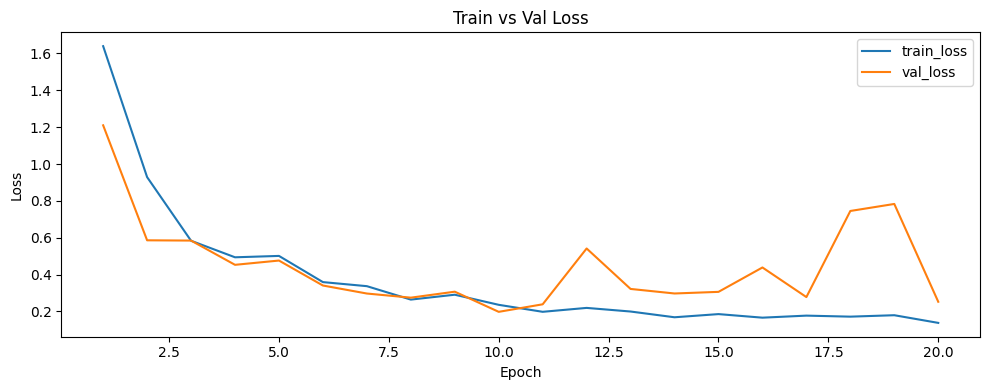

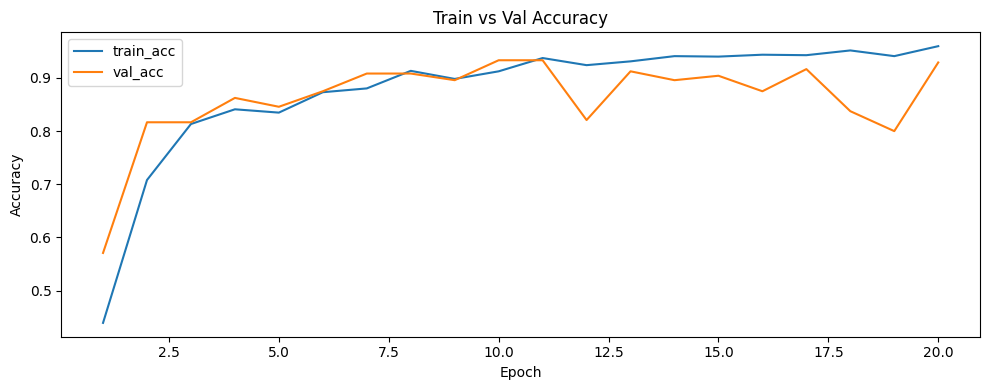

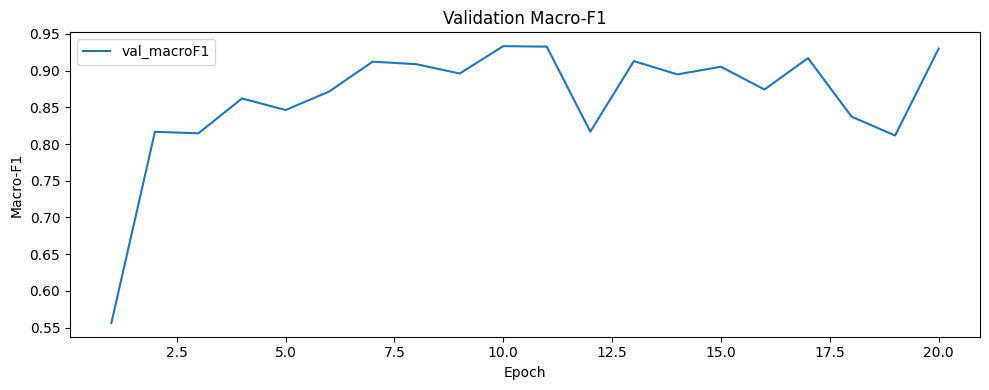

In [ ]:
# -----------------------------
# 10) PLOTS AFTER TRAINING
# -----------------------------
import pandas as pd

df = pd.read_csv(CSV_PATH)
plt.figure(figsize=(10,4))
plt.plot(df["epoch"], df["train_loss"], label="train_loss")
plt.plot(df["epoch"], df["val_loss"],   label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Train vs Val Loss"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(df["epoch"], df["train_acc"], label="train_acc")
plt.plot(df["epoch"], df["val_acc"],   label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Train vs Val Accuracy"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(df["epoch"], df["val_macroF1"], label="val_macroF1")
plt.xlabel("Epoch"); plt.ylabel("Macro-F1"); plt.title("Validation Macro-F1"); plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
# ============================================================
# Step 11 — Final Testing (with best checkpoint)
# - Overall test on the current setup's test split (DATA_ROOT)
# - Per-magnification tests using separate 100× and 400× roots
#   (set DATA_ROOT_100X / DATA_ROOT_400X)
# ============================================================

import time, json
from pathlib import Path
from typing import Dict, Any, Tuple, List

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    precision_recall_fscore_support, confusion_matrix
)
import pandas as pd



In [ ]:
# ---------- Config (EDIT the two lines below for your per-mag roots) ----------
DATA_ROOT_100X = "/content/drive/MyDrive/100x"   # <-- set your 100× setup root
DATA_ROOT_400X = "/content/drive/MyDrive/400x"   # <-- set your 400× setup root

EVAL_DIR = Path(RUN_DIR) / "eval"
EVAL_DIR.mkdir(parents=True, exist_ok=True)



In [ ]:
# ---------- Helper: Load best checkpoint ----------
def load_best(model: torch.nn.Module, ckpt_path: Path) -> Dict[str, Any]:
    ckpt = torch.load(ckpt_path, map_location="cpu")
    model.load_state_dict(ckpt["model_state"], strict=True)
    model.to(DEVICE).eval()
    return ckpt

# ---------- Helper: Build test loader for a given setup root ----------
def build_test_loader(setup_root: str, classes: List[str], batch_size: int = 64) -> DataLoader:
    ds = HistopathologyFolderDataset(
        setup_root, split="testing",
        classes=classes,                # ensure class-id mapping matches training
        input_size=224,
        transform_policy="baseline",    # deterministic eval pipeline
        stain_ablation=None
    )
    return DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True), ds



In [ ]:
# ---------- Helper: Evaluate one loader (no TTA for simplicity) ----------
@torch.no_grad()
def evaluate_loader(model, loader: DataLoader, device: torch.device, class_names: List[str]) -> Dict[str, Any]:
    all_logits, all_targets = [], []
    n_images = 0

    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    t0 = time.perf_counter()
    for images, targets in loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        logits = model(images)
        all_logits.append(logits.cpu())
        all_targets.append(targets.cpu())
        n_images += targets.size(0)
    total_time = time.perf_counter() - t0

    logits  = torch.cat(all_logits)
    targets = torch.cat(all_targets).numpy()
    preds   = logits.argmax(dim=1).numpy()

    acc   = accuracy_score(targets, preds)
    bacc  = balanced_accuracy_score(targets, preds)
    mf1   = f1_score(targets, preds, average="macro")

    prec, rec, f1, support = precision_recall_fscore_support(
        targets, preds, labels=list(range(len(class_names))), zero_division=0
    )
    per_class = {
        class_names[i]: {
            "precision": float(prec[i]),
            "recall":    float(rec[i]),
            "f1":        float(f1[i]),
            "support":   int(support[i])
        } for i in range(len(class_names))
    }

    cm = confusion_matrix(targets, preds, labels=list(range(len(class_names))))

    peak_mb = 0.0
    if torch.cuda.is_available():
        peak_mb = torch.cuda.max_memory_allocated() / (1024**2)

    return {
        "n_images": n_images,
        "accuracy": float(acc),
        "balanced_accuracy": float(bacc),
        "macro_F1": float(mf1),
        "per_class": per_class,
        "confusion_matrix": cm.tolist(),
        "latency_sec_total": float(total_time),
        "latency_ms_per_image": float((total_time / max(1, n_images)) * 1000.0),
        "throughput_img_per_sec": float(n_images / max(1e-8, total_time)),
        "peak_gpu_mem_mb": float(peak_mb),
    }



In [ ]:
# ---------- Helper: Plot and save confusion matrix ----------
def plot_confusion_matrix(cm: np.ndarray, class_names: List[str], title: str, out_path: Path):
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(out_path, bbox_inches='tight', dpi=150)
    plt.show()

# ---------- 1) Load best checkpoint ----------
if ckpt_mgr.best_path is None:
    raise FileNotFoundError("No best checkpoint found. Train (Step 7–9) first.")
ckpt_info = load_best(model, ckpt_mgr.best_path)
print(f"[Eval] Loaded best checkpoint: {ckpt_mgr.best_path} (epoch={ckpt_info.get('epoch')})")

# Ensure we use the *same* class order as training
CLASS_NAMES = train_ds.classes



[Eval] Loaded best checkpoint: /content/drive/MyDrive/DEITMixed_BreakHis/runs/20250914_164244/checkpoints/best_val_macroF1.pth (epoch=10)


[Eval] Overall test:
   accuracy  balanced_accuracy  macro_F1  images  throughput/s  peak_mem_MB
0  0.920833           0.920833  0.920017     240      2.095186   528.003906


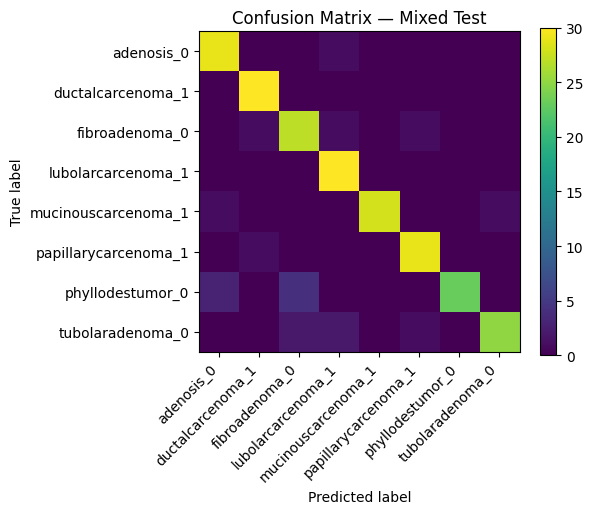

In [ ]:
# ---------- 2) Evaluate on current setup (overall test) ----------
test_loader, test_ds = build_test_loader(DATA_ROOT, CLASS_NAMES, batch_size=64)
res_overall = evaluate_loader(model, test_loader, DEVICE, CLASS_NAMES)

with open(EVAL_DIR / "results_overall.json", "w") as f:
    json.dump(res_overall, f, indent=2)
print("[Eval] Overall test:")
print(pd.DataFrame([{
    "accuracy": res_overall["accuracy"],
    "balanced_accuracy": res_overall["balanced_accuracy"],
    "macro_F1": res_overall["macro_F1"],
    "images": res_overall["n_images"],
    "throughput/s": res_overall["throughput_img_per_sec"],
    "peak_mem_MB": res_overall["peak_gpu_mem_mb"]
}]))

plot_confusion_matrix(
    np.array(res_overall["confusion_matrix"]),
    CLASS_NAMES,
    title="Confusion Matrix — Mixed Test",
    out_path=EVAL_DIR / "cm_overall.png"
)




[Eval] 100× test:
   accuracy  balanced_accuracy  macro_F1  images  throughput/s  peak_mem_MB
0  0.920833           0.920833  0.921209     240      2.132859   528.597656


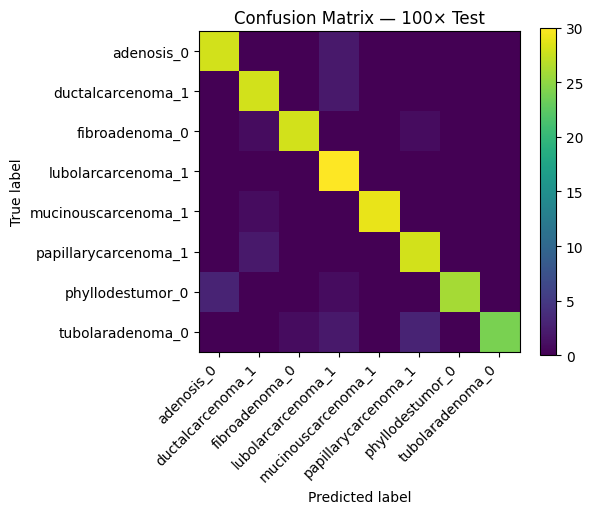

In [ ]:
# ---------- 3) Per-magnification: 100× ----------
test_loader_100, test_ds_100 = build_test_loader(DATA_ROOT_100X, CLASS_NAMES, batch_size=64)
res_100 = evaluate_loader(model, test_loader_100, DEVICE, CLASS_NAMES)
with open(EVAL_DIR / "results_100x.json", "w") as f:
    json.dump(res_100, f, indent=2)
print("[Eval] 100× test:")
print(pd.DataFrame([{
    "accuracy": res_100["accuracy"],
    "balanced_accuracy": res_100["balanced_accuracy"],
    "macro_F1": res_100["macro_F1"],
    "images": res_100["n_images"],
    "throughput/s": res_100["throughput_img_per_sec"],
    "peak_mem_MB": res_100["peak_gpu_mem_mb"]
}]))

plot_confusion_matrix(
    np.array(res_100["confusion_matrix"]),
    CLASS_NAMES,
    title="Confusion Matrix — 100× Test",
    out_path=EVAL_DIR / "cm_100x.png"
)



[Eval] 400× test:
   accuracy  balanced_accuracy  macro_F1  images  throughput/s  peak_mem_MB
0  0.933333           0.933333  0.932727     240       2.33721   528.597656


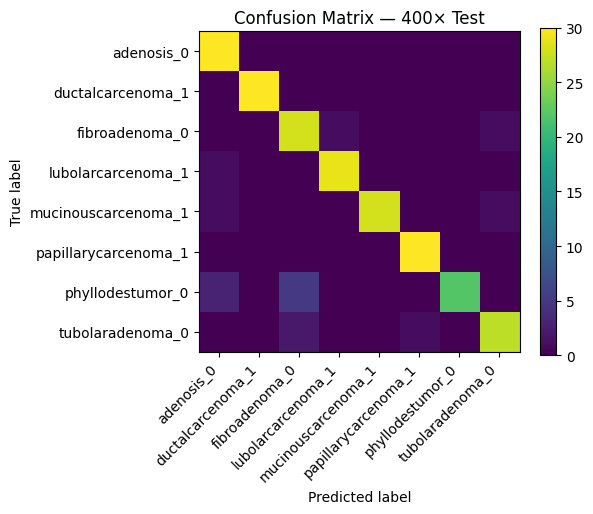

In [ ]:
# ---------- 4) Per-magnification: 400× ----------
test_loader_400, test_ds_400 = build_test_loader(DATA_ROOT_400X, CLASS_NAMES, batch_size=64)
res_400 = evaluate_loader(model, test_loader_400, DEVICE, CLASS_NAMES)
with open(EVAL_DIR / "results_400x.json", "w") as f:
    json.dump(res_400, f, indent=2)
print("[Eval] 400× test:")
print(pd.DataFrame([{
    "accuracy": res_400["accuracy"],
    "balanced_accuracy": res_400["balanced_accuracy"],
    "macro_F1": res_400["macro_F1"],
    "images": res_400["n_images"],
    "throughput/s": res_400["throughput_img_per_sec"],
    "peak_mem_MB": res_400["peak_gpu_mem_mb"]
}]))

plot_confusion_matrix(
    np.array(res_400["confusion_matrix"]),
    CLASS_NAMES,
    title="Confusion Matrix — 400× Test",
    out_path=EVAL_DIR / "cm_400x.png"
)



In [ ]:
print(f"\n[Eval] Saved results to: {EVAL_DIR}")


[Eval] Saved results to: /content/drive/MyDrive/DEITMixed_BreakHis/runs/20250914_164244/eval


In [ ]:
# ============================================
# Step 11 — Subgroup & Fairness-Style Analysis (simple add-on)
# Works with earlier Step-10 results dicts:
#   res_overall, res_100, res_400  (from evaluate_loader)
# Requires CLASS_NAMES (same order as training)
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def subgroup_summary(res_100: dict, res_400: dict) -> pd.DataFrame:
    """
    Returns a 1-row DataFrame summarizing macro-F1 and latency for 100× vs 400×.
    """
    row = {
        "macro_F1_100x": res_100["macro_F1"],
        "macro_F1_400x": res_400["macro_F1"],
        "Δ_macro_F1_(400x-100x)": res_400["macro_F1"] - res_100["macro_F1"],
        "acc_100x": res_100["accuracy"],
        "acc_400x": res_400["accuracy"],
        "balanced_acc_100x": res_100["balanced_accuracy"],
        "balanced_acc_400x": res_400["balanced_accuracy"],
        "latency_ms/img_100x": res_100["latency_ms_per_image"],
        "latency_ms/img_400x": res_400["latency_ms_per_image"],
        "throughput_img/s_100x": res_100["throughput_img_per_sec"],
        "throughput_img/s_400x": res_400["throughput_img_per_sec"],
    }
    return pd.DataFrame([row])

def per_class_f1_table(res_100: dict, res_400: dict, class_names: list) -> pd.DataFrame:
    """
    Builds a per-class F1 comparison table: F1@100×, F1@400×, and delta.
    """
    f1_100 = []
    f1_400 = []
    for cls in class_names:
        f1_100.append(res_100["per_class"][cls]["f1"])
        f1_400.append(res_400["per_class"][cls]["f1"])
    df = pd.DataFrame({
        "class": class_names,
        "F1_100x": f1_100,
        "F1_400x": f1_400,
    })
    df["Δ_F1_(400x-100x)"] = df["F1_400x"] - df["F1_100x"]
    df = df.sort_values("Δ_F1_(400x-100x)", ascending=False).reset_index(drop=True)
    return df

def plot_macroF1_bars(res_100: dict, res_400: dict, title="Macro-F1 by magnification"):
    vals = [res_100["macro_F1"], res_400["macro_F1"]]
    plt.figure(figsize=(4,4))
    plt.bar(["100×","400×"], vals)
    plt.ylabel("Macro-F1")
    plt.title(title)
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()

def plot_per_class_delta(df_cls: pd.DataFrame, title="Per-class ΔF1 (400× - 100×)"):
    plt.figure(figsize=(8, 5))
    plt.barh(df_cls["class"], df_cls["Δ_F1_(400x-100x)"])
    plt.axvline(0, linestyle="--")
    plt.xlabel("ΔF1 (400× - 100×)")
    plt.title(title)
    plt.tight_layout()
    plt.show()




In [ ]:
def per_class_f1_all(res_100: dict, res_400: dict, res_mixed: dict, class_names: list) -> pd.DataFrame:
    df = pd.DataFrame({
        "class": class_names,
        "F1_100x": [res_100["per_class"][c]["f1"]  for c in class_names],
        "F1_400x": [res_400["per_class"][c]["f1"]  for c in class_names],
        "F1_mixed":[res_mixed["per_class"][c]["f1"] for c in class_names],
    })
    df["Δ_mixed-100x"] = df["F1_mixed"] - df["F1_100x"]
    df["Δ_mixed-400x"] = df["F1_mixed"] - df["F1_400x"]
    return df.sort_values("Δ_mixed-100x", ascending=False).reset_index(drop=True)

df_per_class = per_class_f1_all(res_100, res_400, res_overall, CLASS_NAMES)
display(df_per_class.head(10))


class   F1_100x   F1_400x  F1_mixed  Δ_mixed-100x  \
0     ductalcarcenoma_1  0.903226  1.000000  0.967742      0.064516   
1  papillarycarcenoma_1  0.903226  0.983607  0.950820      0.047594   
2    lubolarcarcenoma_1  0.895522  0.966667  0.937500      0.041978   
3      tubolaradenoma_0  0.888889  0.915254  0.892857      0.003968   
4            adenosis_0  0.918033  0.923077  0.920635      0.002602   
5   mucinouscarcenoma_1  0.983051  0.965517  0.965517     -0.017534   
6      phyllodestumor_0  0.928571  0.846154  0.867925     -0.060647   
7        fibroadenoma_0  0.949153  0.861538  0.857143     -0.092010   

   Δ_mixed-400x  
0     -0.032258  
1     -0.032787  
2     -0.029167  
3     -0.022397  
4     -0.002442  
5      0.000000  
6      0.021771  
7     -0.004396

In [ ]:
import pandas as pd

def subgroup_summary_all(res_100: dict, res_400: dict, res_mixed: dict) -> pd.DataFrame:
    rows = []
    rows.append({"group": "100x",  "macro_F1": res_100["macro_F1"],  "acc": res_100["accuracy"],
                 "balanced_acc": res_100["balanced_accuracy"], "latency_ms/img": res_100["latency_ms_per_image"],
                 "throughput_img/s": res_100["throughput_img_per_sec"]})
    rows.append({"group": "400x",  "macro_F1": res_400["macro_F1"],  "acc": res_400["accuracy"],
                 "balanced_acc": res_400["balanced_accuracy"], "latency_ms/img": res_400["latency_ms_per_image"],
                 "throughput_img/s": res_400["throughput_img_per_sec"]})
    rows.append({"group": "mixed", "macro_F1": res_mixed["macro_F1"], "acc": res_mixed["accuracy"],
                 "balanced_acc": res_mixed["balanced_accuracy"], "latency_ms/img": res_mixed["latency_ms_per_image"],
                 "throughput_img/s": res_mixed["throughput_img_per_sec"]})
    df = pd.DataFrame(rows)

    # Deltas (helpful to read impact)
    df["Δ_macro_F1_vs_100x"] = df["macro_F1"] - df.loc[df["group"]=="100x","macro_F1"].values[0]
    df["Δ_macro_F1_vs_400x"] = df["macro_F1"] - df.loc[df["group"]=="400x","macro_F1"].values[0]
    return df

# If this run was the mixed setup, pass res_overall as mixed:
df_summary = subgroup_summary_all(res_100, res_400, res_overall)
display(df_summary)


group  macro_F1       acc  balanced_acc  latency_ms/img  throughput_img/s  \
0   100x  0.921209  0.920833      0.920833      468.854259          2.132859   
1   400x  0.932727  0.933333      0.933333      427.860541          2.337210   
2  mixed  0.920017  0.920833      0.920833      477.284481          2.095186   

   Δ_macro_F1_vs_100x  Δ_macro_F1_vs_400x  
0            0.000000           -0.011518  
1            0.011518            0.000000  
2           -0.001192           -0.012709

In [ ]:
def plot_macroF1_bars(res_100: dict, res_400: dict, res_mixed: dict, title="Macro-F1: 100× vs 400× vs Mixed (overall)"):
    """
    Bar plot of macro-F1 for:
      - 100× test (single magnification)
      - 400× test (single magnification)
      - Mixed setup (overall test)  ← not per-magnification slices
    """
    labels = ["100×", "400×", "Mixed (overall)"]
    vals = [res_100["macro_F1"], res_400["macro_F1"], res_mixed["macro_F1"]]

    plt.figure(figsize=(5.5, 4))
    bars = plt.bar(labels, vals)
    plt.ylabel("Macro-F1")
    plt.title(title)
    plt.ylim(0, 1.0)
    # annotate values
    for b, v in zip(bars, vals):
        plt.text(b.get_x() + b.get_width()/2, v + 0.02, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    plt.show()


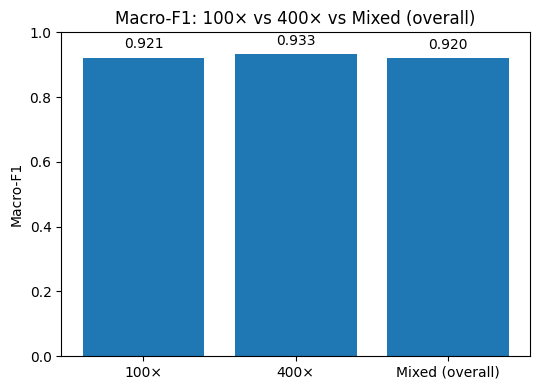

In [ ]:
# If your current run is the mixed setup, pass res_overall as res_mixed:
plot_macroF1_bars(res_100, res_400, res_overall)


In [ ]:
# ============================================================
# Step 12 — Interpretability & Qualitative Checks
# - Attention heatmaps for DeiT (optional: uses pytorch-grad-cam if available)
# - Class exemplars: TP / FP / FN image grids with short captions
# - Failure-mode audit: where do errors cluster (by magnification / class)?
# Prereqs:
#   - model on DEVICE, in eval mode
#   - test load/eval already done: res_overall (mixed overall) + res_100 + res_400
#   - HistopathologyFolderDataset, build_eval_augmentations from earlier
# ============================================================

import os, math, time
from pathlib import Path
from typing import List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

# ---------- 0) Build a deterministic test loader for the CURRENT setup ----------
def build_eval_loader_for_paths(data_root: str, classes: List[str], batch_size: int = 32):
    ds = HistopathologyFolderDataset(
        data_root, split="testing", classes=classes,
        input_size=224, transform_policy="baseline", stain_ablation=None
    )
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return ds, loader




In [ ]:
# ---------- 1) Collect predictions with paths (no shuffling!) ----------
@torch.no_grad()
def collect_predictions(model, ds, loader, device, class_names: List[str]) -> pd.DataFrame:
    """
    Returns a DataFrame with: path, true_id, true_name, pred_id, pred_name, correct, conf
    """
    model.eval()
    all_logits = []
    all_targets = []

    # Keep file paths aligned with loader order (shuffle=False)
    paths_in_order = [p for (p, _) in ds.items]

    for images, targets in loader:
        images = images.to(device, non_blocking=True)
        logits = model(images)
        all_logits.append(logits.cpu())
        all_targets.append(targets)

    logits = torch.cat(all_logits).numpy()
    targets = torch.cat(all_targets).numpy()
    probs = np.exp(logits - logits.max(axis=1, keepdims=True))
    probs = probs / np.clip(probs.sum(axis=1, keepdims=True), 1e-12, None)
    preds = probs.argmax(axis=1)
    confs = probs.max(axis=1)

    df = pd.DataFrame({
        "path": paths_in_order,
        "true_id": targets,
        "pred_id": preds,
        "conf": confs
    })
    df["true_name"] = df["true_id"].apply(lambda i: class_names[i])
    df["pred_name"] = df["pred_id"].apply(lambda i: class_names[i])
    df["correct"] = (df["true_id"] == df["pred_id"]).astype(int)
    return df



In [ ]:
# ---------- 2) Show exemplars (TP / FP / FN) ----------
def show_examples(df: pd.DataFrame, cls_name: str, kind: str = "TP", k: int = 3):
    """
    kind: "TP" | "FP" | "FN"
      TP: true==pred==cls
      FP: pred==cls, true!=cls
      FN: true==cls, pred!=cls
    """
    if kind == "TP":
        sel = df[(df.true_name == cls_name) & (df.pred_name == cls_name)]
        title = f"{cls_name} — True Positives"
    elif kind == "FP":
        sel = df[(df.pred_name == cls_name) & (df.true_name != cls_name)]
        title = f"{cls_name} — False Positives (predicted as {cls_name})"
    elif kind == "FN":
        sel = df[(df.true_name == cls_name) & (df.pred_name != cls_name)]
        title = f"{cls_name} — False Negatives (missed {cls_name})"
    else:
        raise ValueError("kind must be TP|FP|FN")

    samples = sel.sort_values("conf", ascending=False).head(k)  # show confident cases first
    n = len(samples)
    if n == 0:
        print(f"No {kind} examples for {cls_name}.")
        return

    cols = min(k, 3)
    rows = math.ceil(n / cols)
    plt.figure(figsize=(4*cols, 4*rows))
    for i, (_, row) in enumerate(samples.iterrows(), 1):
        img = load_image_rgb(row["path"])
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")
        cap = f"true: {row['true_name']}\npred: {row['pred_name']} (conf {row['conf']:.2f})"
        plt.title(cap, fontsize=9)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



In [ ]:
# ---------- 4) Failure-mode audit (magnification & class) ----------
def failure_mode_tables(res_100: dict, res_400: dict, class_names: List[str]) -> pd.DataFrame:
    """
    Combines confusion matrices from 100× and 400× to show per-class error rates.
    Returns a dataframe with per-class accuracy at 100× and 400× plus deltas.
    """
    cm100 = np.array(res_100["confusion_matrix"])
    cm400 = np.array(res_400["confusion_matrix"])

    def per_class_acc(cm):
        correct = np.diag(cm)
        support = cm.sum(axis=1).clip(min=1)
        return correct / support

    acc100 = per_class_acc(cm100)
    acc400 = per_class_acc(cm400)

    df = pd.DataFrame({
        "class": class_names,
        "acc_100x": acc100,
        "acc_400x": acc400,
    })
    df["Δacc_(400x-100x)"] = df["acc_400x"] - df["acc_100x"]
    return df.sort_values("Δacc_(400x-100x)", ascending=False).reset_index(drop=True)



In [ ]:
# -----------------------------
# Example usage (run what you need)
# -----------------------------

# CURRENT setup (e.g., mixed overall):
test_ds_cur, test_loader_cur = build_eval_loader_for_paths(DATA_ROOT, CLASS_NAMES, batch_size=32)
df_pred = collect_predictions(model, test_ds_cur, test_loader_cur, DEVICE, CLASS_NAMES)




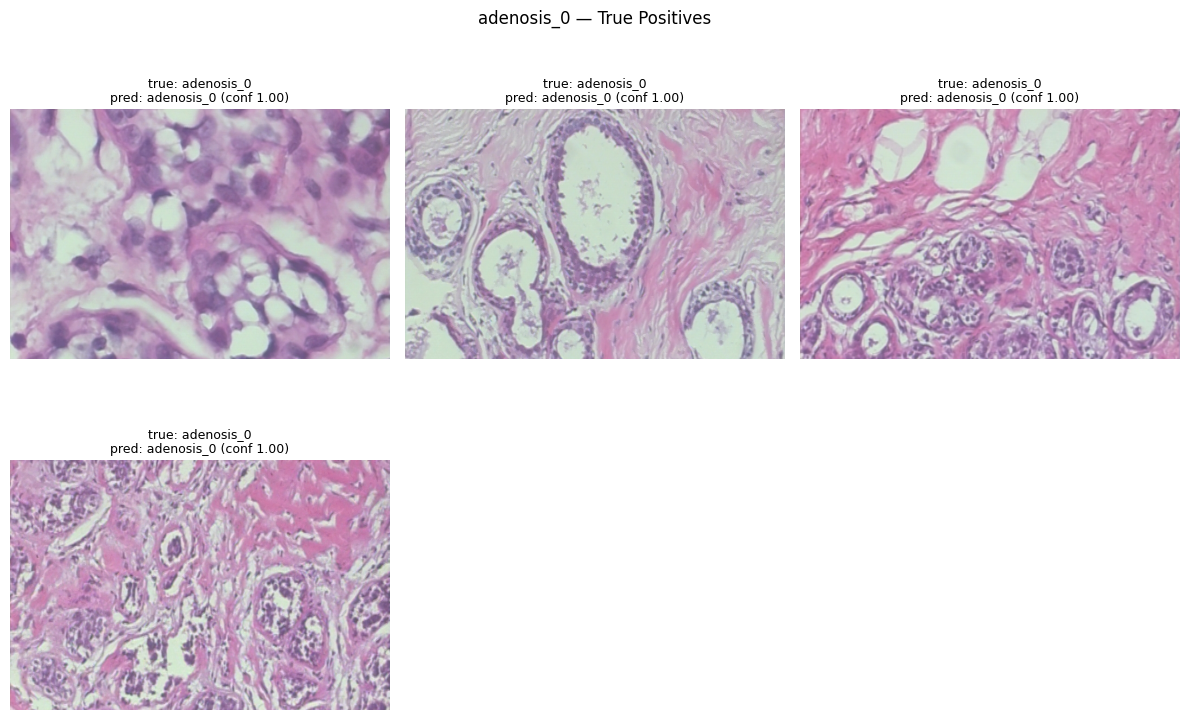

In [ ]:
# 1) Exemplars
show_examples(df_pred, cls_name=CLASS_NAMES[0], kind="TP", k=4)



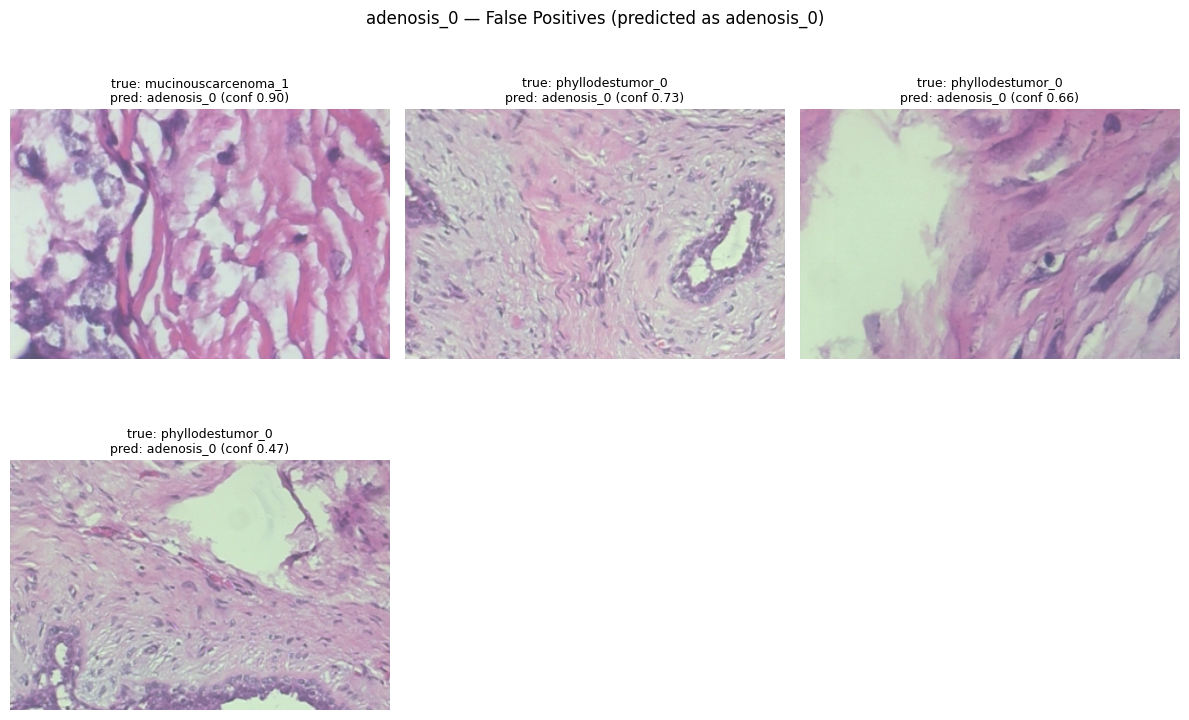

In [ ]:
show_examples(df_pred, cls_name=CLASS_NAMES[0], kind="FP", k=4)


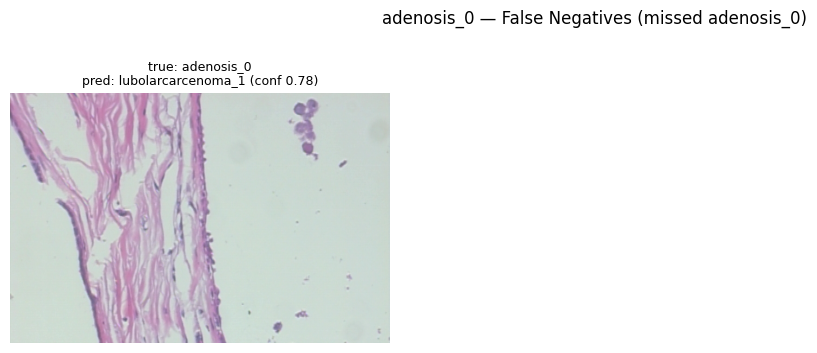

In [ ]:
show_examples(df_pred, cls_name=CLASS_NAMES[0], kind="FN", k=4)

In [ ]:
# 3) Failure-mode audit using your per-mag results from Step 10
df_fail = failure_mode_tables(res_100, res_400, CLASS_NAMES)
print(df_fail.head(10))

                  class  acc_100x  acc_400x  Δacc_(400x-100x)
0      tubolaradenoma_0  0.800000  0.900000          0.100000
1            adenosis_0  0.933333  1.000000          0.066667
2  papillarycarcenoma_1  0.933333  1.000000          0.066667
3     ductalcarcenoma_1  0.933333  1.000000          0.066667
4        fibroadenoma_0  0.933333  0.933333          0.000000
5    lubolarcarcenoma_1  1.000000  0.966667         -0.033333
6   mucinouscarcenoma_1  0.966667  0.933333         -0.033333
7      phyllodestumor_0  0.866667  0.733333         -0.133333
